<a href="https://colab.research.google.com/github/jiuyuanx/94812-Application-of-NLP-and-LLM/blob/main/StockPrediction_withNLP/GameStop(GME)Forecasting_LSTM_Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip yfinance -q
!pip install torchmetrics -q
!pip install torchsummaryX -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 16.3 MB/s eta 0:00:00


In [2]:
import yfinance as yf
import seaborn as sns
import random
import numpy as np
import pandas as pd
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummaryX import summary
from tqdm.auto import tqdm
import os
import gc
from matplotlib import pyplot as plt
from pandas_datareader import data as pdr
import datetime
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
from torchmetrics.regression import MeanAbsolutePercentageError

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


cuda:0


In [3]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from scipy.stats import spearmanr as spearman
def get_metrics(prediction, true_labels):
  metrics = ['MSE', 'RMSE','MAE', 'MAPE', 'Serial Corr', 'Pearson Corr(IC),', 'Spearman Corr(IC)']
  metrics_value = [
  MSE(prediction,true_labels),
  MSE(prediction,true_labels)**0.5,
  MAE(prediction,true_labels),
  MAPE(prediction,true_labels),
  np.corrcoef(prediction,true_labels)[0,1],
  np.corrcoef(np.diff(prediction),np.diff(true_labels))[0,1],
  spearman(np.diff(prediction),np.diff(true_labels))[0],
  ]

  return pd.DataFrame([metrics_value], columns=metrics)


# **Load Reddit News & Create Dataset of Time Series News Combined**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df_reddit = pd.read_csv("/content/drive/MyDrive/94812/prediction/rGME_dataset_features.csv")[['date','title','score','num_comments']]
df_reddit

<ipython-input-5-a632c92e08de>:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_reddit = pd.read_csv("/content/drive/MyDrive/94812/prediction/rGME_dataset_features.csv")[['date','title','score','num_comments']]


date                                              title  score  \
0        2021-01-04              You NEED to see this about GME 🚀🚀🚀🚀🚀🚀    1.0   
1        2021-01-04                     Short Squeeze Incoming 🚀🚀🚀🚀🚀🚀🚀    1.0   
2        2021-01-05  THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...    1.0   
3        2021-01-05  You already know what we must do brothers and ...    1.0   
4        2021-01-06                          ICR conference (11th Jan)    1.0   
...             ...                                                ...    ...   
1033231  2021-12-31  Hedgies are relics of past generations- they h...    1.0   
1033232  2021-12-31                                    Snapchat on 🔥🔥🔥    1.0   
1033233  2021-12-31  MOASS has ruined me this year. But I will stil...    1.0   
1033234  2021-12-31                               Patterns for 2022???    1.0   
1033235  2021-12-31                                        When GWagon    1.0   

         num_comments  
0                 9.0  
1                 1.0  
2                 6.0  
3                 4.0  
4                10.0  
...               ...  
1033231           0.0  
1033232           0.0  
1033233           0.0  
1033234           0.0  
1033235           0.0  

[1033236 rows x 4 columns]

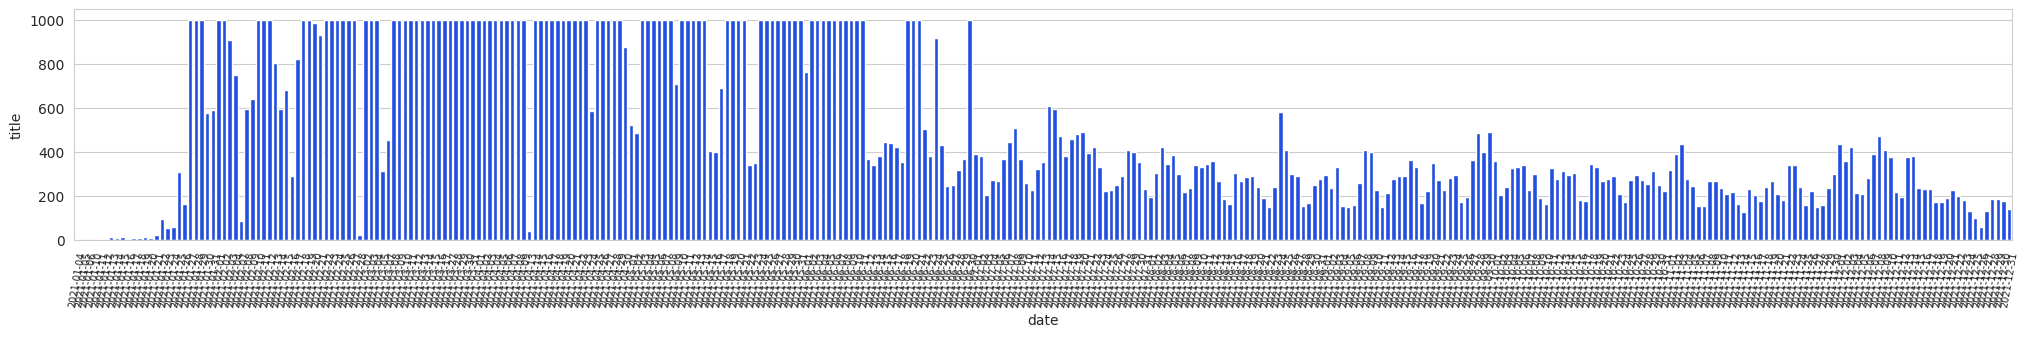

In [6]:
plt.figure(figsize=(25,3))
sns.set_style("whitegrid")
sns.set_palette("bright")
df_count = df_reddit.groupby('date').count().reset_index()
df_count['title']=df_count['title'].clip(0,1000)
sns.barplot(df_count, x='date', y='title')
plt.xticks(rotation=80, fontsize=7)
plt.show()

In [7]:
!pip install emoji -q
import emoji

def clean_text(text):
    import re
    text = emoji.demojize(text, delimiters=(" ", " "))  #emojis are important, keep them
    cleaned_text = re.sub(r'[^\w\s]', '', text)
    cleaned_text = cleaned_text.lower()
    return cleaned_text
df_reddit['title'] = df_reddit['title'].map(clean_text)
df_reddit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 9.0 MB/s eta 0:00:00


date                                              title  score  \
0        2021-01-04  you need to see this about gme  rocket  rocket...    1.0   
1        2021-01-04  short squeeze incoming  rocket  rocket  rocket...    1.0   
2        2021-01-05  this convinced me to all in  money_bag gme ext...    1.0   
3        2021-01-05  you already know what we must do brothers and ...    1.0   
4        2021-01-06                            icr conference 11th jan    1.0   
...             ...                                                ...    ...   
1033231  2021-12-31  hedgies are relics of past generations they ha...    1.0   
1033232  2021-12-31                     snapchat on  fire  fire  fire     1.0   
1033233  2021-12-31  moass has ruined me this year but i will still...    1.0   
1033234  2021-12-31                                  patterns for 2022    1.0   
1033235  2021-12-31                                        when gwagon    1.0   

         num_comments  
0                 9.0  
1                 1.0  
2                 6.0  
3                 4.0  
4                10.0  
...               ...  
1033231           0.0  
1033232           0.0  
1033233           0.0  
1033234           0.0  
1033235           0.0  

[1033236 rows x 4 columns]

## **Each day sample 300 news**

In [8]:
df_news = df_reddit.groupby('date').apply(lambda x: x.sample(min(len(x), 300))).reset_index(drop=True)
df_news

date                                              title  score  \
0      2021-01-04  short squeeze incoming  rocket  rocket  rocket...    1.0   
1      2021-01-04  you need to see this about gme  rocket  rocket...    1.0   
2      2021-01-05  this convinced me to all in  money_bag gme ext...    1.0   
3      2021-01-05  you already know what we must do brothers and ...    1.0   
4      2021-01-06                            icr conference 11th jan    1.0   
...           ...                                                ...    ...   
87686  2021-12-31                                sec report debunked    1.0   
87687  2021-12-31   purple_circle  pool activated the rest will b...    1.0   
87688  2021-12-31                   mayo bowl any sightings of kenny    1.0   
87689  2021-12-31  last of year purchase another xx at limit orde...    1.0   
87690  2021-12-31                                      2021 timeline    1.0   

       num_comments  
0               1.0  
1               9.0  
2               6.0  
3               4.0  
4              10.0  
...             ...  
87686           0.0  
87687           0.0  
87688           0.0  
87689           0.0  
87690           0.0  

[87691 rows x 4 columns]

## **Load Time Series and Combine with News**

In [9]:
df = pd.read_csv('/content/drive/MyDrive/94812/prediction/s&p500_stocks.csv', index_col=[0], header=[0,1]).drop('Adj Close', level='Attribute', axis=1)
df.index = pd.to_datetime(df.index)
df = df.loc[:,('GME')].reset_index()
df

Attribute       Date     Open     High     Low    Close    Volume
0         2018-01-02   4.4900   4.5725   4.445   4.5650  11330800
1         2018-01-03   4.5725   4.5925   4.480   4.5500  15156800
2         2018-01-04   4.5500   4.5950   4.490   4.5800  11125200
3         2018-01-05   4.5950   4.6825   4.555   4.6700  12076000
4         2018-01-08   4.7000   4.8500   4.700   4.8075  14673600
...              ...      ...      ...     ...      ...       ...
1523      2024-01-23  15.0000  15.0200  14.050  14.1800   3495300
1524      2024-01-24  14.2800  14.3800  13.820  13.9500   2513800
1525      2024-01-25  13.9700  14.5400  13.920  14.5200   3635900
1526      2024-01-26  14.4400  14.7200  14.410  14.4900   2282300
1527      2024-01-29  14.5000  14.8100  14.320  14.7800   2164200

[1528 rows x 6 columns]

In [10]:
df_news['date'] = pd.to_datetime(df_news['date'])
df_gme_full=df_news.merge(df, how ='inner', left_on = 'date', right_on='Date').drop(columns=['date'])
df_gme_full

title  score  num_comments  \
0      short squeeze incoming  rocket  rocket  rocket...    1.0           1.0   
1      you need to see this about gme  rocket  rocket...    1.0           9.0   
2      this convinced me to all in  money_bag gme ext...    1.0           6.0   
3      you already know what we must do brothers and ...    1.0           4.0   
4                                icr conference 11th jan    1.0          10.0   
...                                                  ...    ...           ...   
65056                                sec report debunked    1.0           0.0   
65057   purple_circle  pool activated the rest will b...    1.0           0.0   
65058                   mayo bowl any sightings of kenny    1.0           0.0   
65059  last of year purchase another xx at limit orde...    1.0           0.0   
65060                                      2021 timeline    1.0           0.0   

            Date       Open       High        Low    Close    Volume  
0     2021-01-04   4.750000   4.775000   4.287500   4.3125  40090000  
1     2021-01-04   4.750000   4.775000   4.287500   4.3125  40090000  
2     2021-01-05   4.337500   4.520000   4.307500   4.3425  19846000  
3     2021-01-05   4.337500   4.520000   4.307500   4.3425  19846000  
4     2021-01-06   4.335000   4.745000   4.332500   4.5900  24224800  
...          ...        ...        ...        ...      ...       ...  
65056 2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000  
65057 2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000  
65058 2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000  
65059 2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000  
65060 2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000  

[65061 rows x 9 columns]

## **How many News each day vs Stock Price**

<ipython-input-11-43fc03da01ce>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=80)


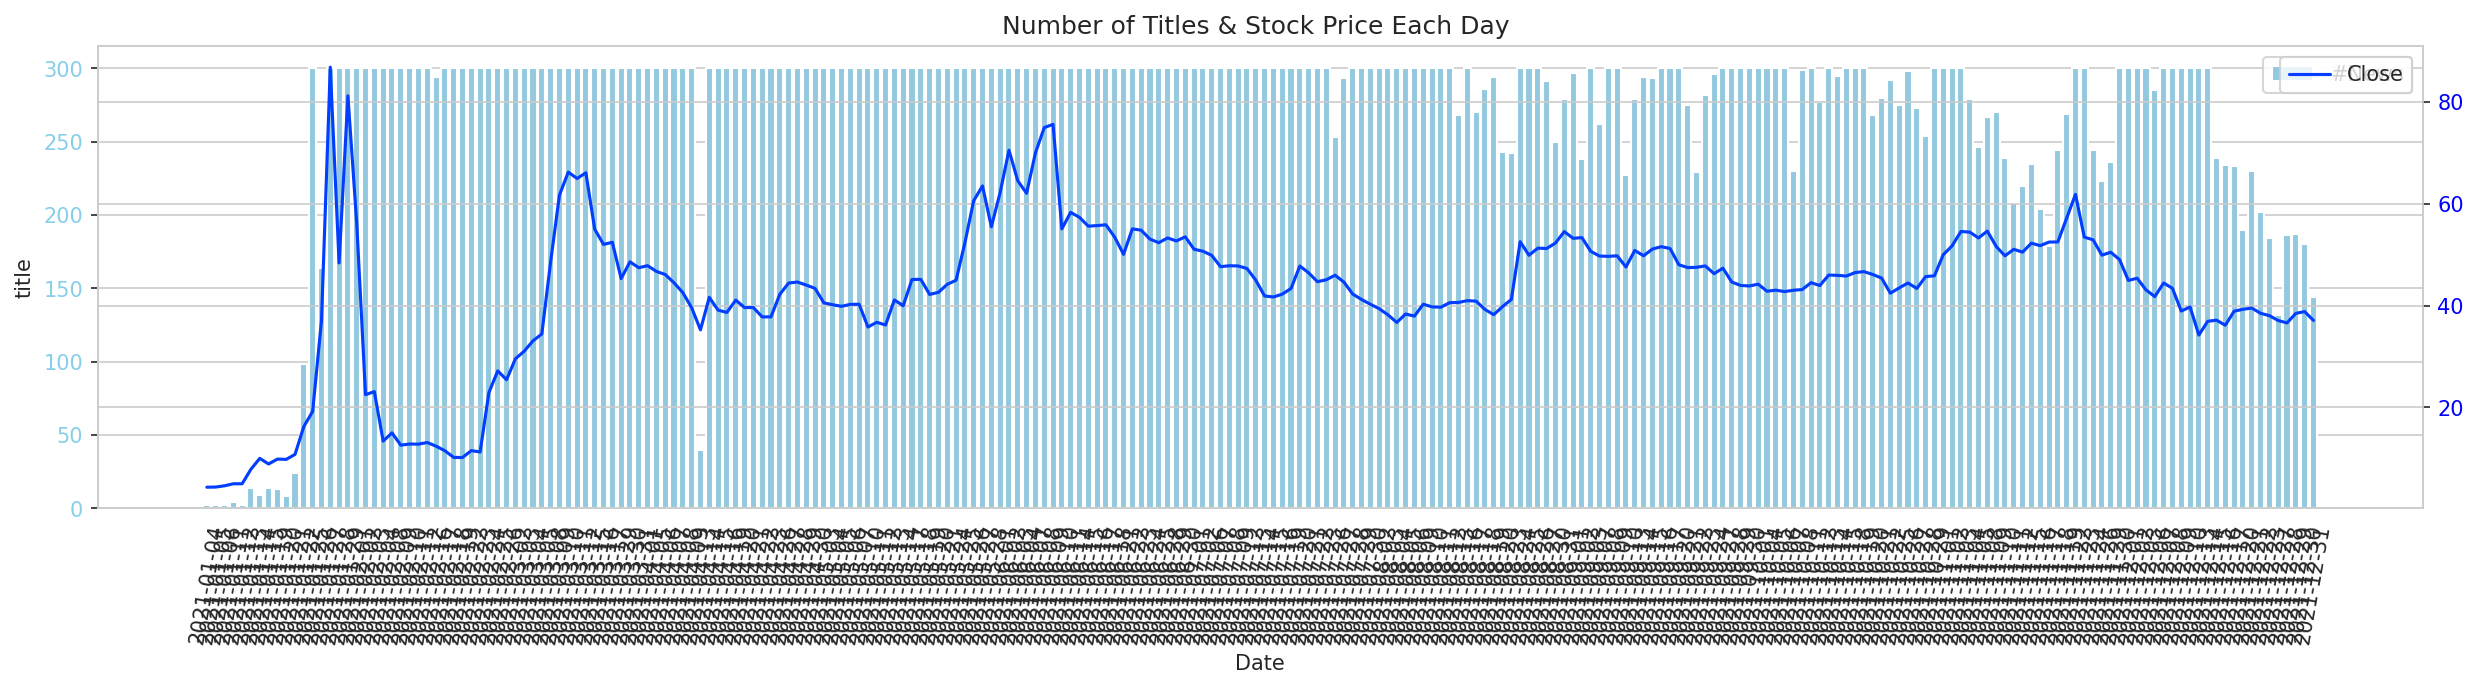

In [11]:
fig, ax1 = plt.subplots(figsize=(20, 4), dpi=150)
color = 'skyblue'
num_titles = df_gme_full[df_gme_full['Date']>pd.to_datetime('2020-11-30')][['Date','title']].groupby('Date').count().reset_index()
# num_titles['Date'] = num_titles['Date'].apply(lambda x: str(x))
sns.barplot(num_titles, x='Date', y='title',color=color, ax=ax1, label="#News")
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=80)

ax2 = ax1.twinx()
color = 'blue'
price = df_gme_full[df_gme_full['Date']>pd.to_datetime('2020-11-30')][['Date','Close']].groupby('Date').mean().reset_index()
# price['Date'] = price['Date'].apply(lambda x: str(x))
sns.lineplot(price, color=color, ax=ax2)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Number of Titles & Stock Price Each Day ")
plt.show()

In [12]:
df_gme_full.to_csv("2021_ts_news.csv")

# **Load Time Series & News Combined**

In [13]:
df = df_gme_full
# df = pd.read_csv('/content/drive/MyDrive/94812/prediction/2021_ts_news.csv').drop(columns=['Unnamed: 0','score','num_comments']).dropna()
df

title  score  num_comments  \
0      short squeeze incoming  rocket  rocket  rocket...    1.0           1.0   
1      you need to see this about gme  rocket  rocket...    1.0           9.0   
2      this convinced me to all in  money_bag gme ext...    1.0           6.0   
3      you already know what we must do brothers and ...    1.0           4.0   
4                                icr conference 11th jan    1.0          10.0   
...                                                  ...    ...           ...   
65056                                sec report debunked    1.0           0.0   
65057   purple_circle  pool activated the rest will b...    1.0           0.0   
65058                   mayo bowl any sightings of kenny    1.0           0.0   
65059  last of year purchase another xx at limit orde...    1.0           0.0   
65060                                      2021 timeline    1.0           0.0   

            Date       Open       High        Low    Close    Volume  
0     2021-01-04   4.750000   4.775000   4.287500   4.3125  40090000  
1     2021-01-04   4.750000   4.775000   4.287500   4.3125  40090000  
2     2021-01-05   4.337500   4.520000   4.307500   4.3425  19846000  
3     2021-01-05   4.337500   4.520000   4.307500   4.3425  19846000  
4     2021-01-06   4.335000   4.745000   4.332500   4.5900  24224800  
...          ...        ...        ...        ...      ...       ...  
65056 2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000  
65057 2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000  
65058 2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000  
65059 2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000  
65060 2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000  

[65061 rows x 9 columns]

# **Explore Bert Sentiment Analysis**

## **Inference sentiment with Bert fine-tuned**

In [14]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# bert = BertModel.from_pretrained("bert-base-uncased").to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [15]:
def tokenize(x):
  out = tokenizer.encode_plus(x,
        add_special_tokens=True,  # Add [CLS] and [SEP] tokens
        max_length=50,    # Truncate or pad to the maximum length
        truncation=True,          # Enable truncation if text is too long
        padding='max_length',     # Pad to the maximum length
        return_tensors='pt'       # Return PyTorch tensors)
  )

  return out
df_tokenized = df['title'].apply(lambda x: tokenize(x))
df_vec = df_tokenized.values
print("shape of one news:", df_vec[0]['input_ids'].shape)
df_vec[0]

shape of one news: torch.Size([1, 50])


{'input_ids': tensor([[  101,  2460, 11025, 14932,  7596,  7596,  7596,  7596,  7596,  7596,
          7596,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])}

In [16]:
class BERT(nn.Module):
    def __init__(self, bert):
        super(BERT, self).__init__()
        self.bert = bert
        self.mlp = nn.Sequential(
            nn.Linear(768,256),
            nn.LeakyReLU(),
            nn.Linear(256,256),
            nn.LeakyReLU(),
            nn.Linear(256,3)
        )

    def forward(self, x):
        input_ids= x[0].to(device)
        token_type= x[1].to(device)
        att_mask= x[2].to(device)
        out = self.bert(input_ids.to(device),  attention_mask=att_mask.to(device), token_type_ids=token_type.to(device))

        return self.mlp(out.pooler_output)

In [17]:
model = torch.load("/content/drive/MyDrive/94812/prediction/bert_finetuned.pt")
model((df_vec[0].input_ids.to(device), df_vec[0].token_type_ids.to(device), df_vec[0].attention_mask.to(device)))

tensor([[ 1.9833, -1.3301, -0.9498]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [18]:
gc.collect()
torch.cuda.empty_cache()

In [19]:
class NLPDataset(torch.utils.data.Dataset):
    def __init__(self, data) :
        super().__init__()
        self.data = data
        self.input_ids = torch.vstack([i['input_ids'].squeeze() for i in data])
        self.token_type_ids = torch.vstack([i['token_type_ids'].squeeze() for i in data])
        self.att_mask = torch.vstack([i['attention_mask'].squeeze() for i in data])
        # self.label = torch.LongTensor(label)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):

        return (self.input_ids[index], self.token_type_ids[index], self.att_mask[index])

In [20]:
inference_data = NLPDataset(df_vec)
inference_loader = torch.utils.data.DataLoader(
    dataset     = inference_data,
    batch_size  = 328,
    shuffle=False
)


In [21]:
# del X
gc.collect()
torch.cuda.empty_cache()

In [22]:
sentiments = []
for X in tqdm(inference_loader, "inferencing..."):

  res = model(X).cpu().detach().numpy()
  sentiments.append(res)
  del X
  gc.collect()
  torch.cuda.empty_cache()

df_sentiment = df.copy()
df_sentiment['sentiment'] = np.vstack(sentiments).argmax(1)
df_sentiment

inferencing...:   0%|          | 0/199 [00:00<?, ?it/s]

title  score  num_comments  \
0      short squeeze incoming  rocket  rocket  rocket...    1.0           1.0   
1      you need to see this about gme  rocket  rocket...    1.0           9.0   
2      this convinced me to all in  money_bag gme ext...    1.0           6.0   
3      you already know what we must do brothers and ...    1.0           4.0   
4                                icr conference 11th jan    1.0          10.0   
...                                                  ...    ...           ...   
65056                                sec report debunked    1.0           0.0   
65057   purple_circle  pool activated the rest will b...    1.0           0.0   
65058                   mayo bowl any sightings of kenny    1.0           0.0   
65059  last of year purchase another xx at limit orde...    1.0           0.0   
65060                                      2021 timeline    1.0           0.0   

            Date       Open       High        Low    Close    Volume  \
0     2021-01-04   4.750000   4.775000   4.287500   4.3125  40090000   
1     2021-01-04   4.750000   4.775000   4.287500   4.3125  40090000   
2     2021-01-05   4.337500   4.520000   4.307500   4.3425  19846000   
3     2021-01-05   4.337500   4.520000   4.307500   4.3425  19846000   
4     2021-01-06   4.335000   4.745000   4.332500   4.5900  24224800   
...          ...        ...        ...        ...      ...       ...   
65056 2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000   
65057 2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000   
65058 2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000   
65059 2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000   
65060 2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000   

       sentiment  
0              0  
1              0  
2              0  
3              0  
4              0  
...          ...  
65056          0  
65057          0  
65058          0  
65059          0  
65060          0  

[65061 rows x 10 columns]

In [23]:
df_sentiment[['sentiment','Close']].groupby('sentiment').count()

Close
sentiment       
0          49419
1           1479
2          14163

In [24]:
df_sentiment['sentiment'] = df_sentiment['sentiment'].apply(lambda x: -1 if x==2 else x)
df_sentiment

title  score  num_comments  \
0      short squeeze incoming  rocket  rocket  rocket...    1.0           1.0   
1      you need to see this about gme  rocket  rocket...    1.0           9.0   
2      this convinced me to all in  money_bag gme ext...    1.0           6.0   
3      you already know what we must do brothers and ...    1.0           4.0   
4                                icr conference 11th jan    1.0          10.0   
...                                                  ...    ...           ...   
65056                                sec report debunked    1.0           0.0   
65057   purple_circle  pool activated the rest will b...    1.0           0.0   
65058                   mayo bowl any sightings of kenny    1.0           0.0   
65059  last of year purchase another xx at limit orde...    1.0           0.0   
65060                                      2021 timeline    1.0           0.0   

            Date       Open       High        Low    Close    Volume  \
0     2021-01-04   4.750000   4.775000   4.287500   4.3125  40090000   
1     2021-01-04   4.750000   4.775000   4.287500   4.3125  40090000   
2     2021-01-05   4.337500   4.520000   4.307500   4.3425  19846000   
3     2021-01-05   4.337500   4.520000   4.307500   4.3425  19846000   
4     2021-01-06   4.335000   4.745000   4.332500   4.5900  24224800   
...          ...        ...        ...        ...      ...       ...   
65056 2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000   
65057 2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000   
65058 2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000   
65059 2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000   
65060 2021-12-31  38.404999  39.182499  37.025002  37.0975   5576000   

       sentiment  
0              0  
1              0  
2              0  
3              0  
4              0  
...          ...  
65056          0  
65057          0  
65058          0  
65059          0  
65060          0  

[65061 rows x 10 columns]

In [25]:
dff = df_sentiment[df_sentiment.columns.difference(['title'])].groupby('Date').mean()
dff['price_change'] = dff['Close'].diff().fillna(0)
dff['sentiment_change'] = dff['sentiment'].diff().fillna(0)
dff

Close       High        Low       Open      Volume  \
Date                                                                 
2021-01-04   4.312500   4.775000   4.287500   4.750000  40090000.0   
2021-01-05   4.342500   4.520000   4.307500   4.337500  19846000.0   
2021-01-06   4.590000   4.745000   4.332500   4.335000  24224800.0   
2021-01-11   4.985000   5.162500   4.752500   4.852500  59632000.0   
2021-01-12   4.987500   5.100000   4.830000   4.990000  28242800.0   
...               ...        ...        ...        ...         ...   
2021-12-27  37.077499  38.154999  35.000000  38.000000   6454400.0   
2021-12-28  36.615002  39.352501  36.602501  36.875000   5324400.0   
2021-12-29  38.482498  38.872501  35.535000  36.962502   8149600.0   
2021-12-30  38.832500  40.000000  37.500000  37.750000   6247600.0   
2021-12-31  37.097500  39.182499  37.025002  38.404999   5576000.0   

            num_comments     score  sentiment  price_change  sentiment_change  
Date                                                                           
2021-01-04      5.000000  1.000000   0.000000      0.000000          0.000000  
2021-01-05      5.000000  1.000000   0.000000      0.030000          0.000000  
2021-01-06     12.500000  1.000000   0.000000      0.247500          0.000000  
2021-01-11      9.500000  1.250000  -0.250000      0.395000         -0.250000  
2021-01-12     12.000000  1.500000  -0.500000      0.002500         -0.250000  
...                  ...       ...        ...           ...               ...  
2021-12-27      0.007576  1.007576  -0.098485     -0.957500         -0.049572  
2021-12-28      0.010753  1.005376  -0.155914     -0.462498         -0.057429  
2021-12-29      0.010695  1.000000  -0.192513      1.867496         -0.036599  
2021-12-30      0.005556  1.022222  -0.105556      0.350002          0.086958  
2021-12-31      0.013889  1.013889  -0.131944     -1.735001         -0.026389  

[240 rows x 10 columns]

## **Correlation between Sentiment & Price**

<Axes: xlabel='Date', ylabel='price_change'>

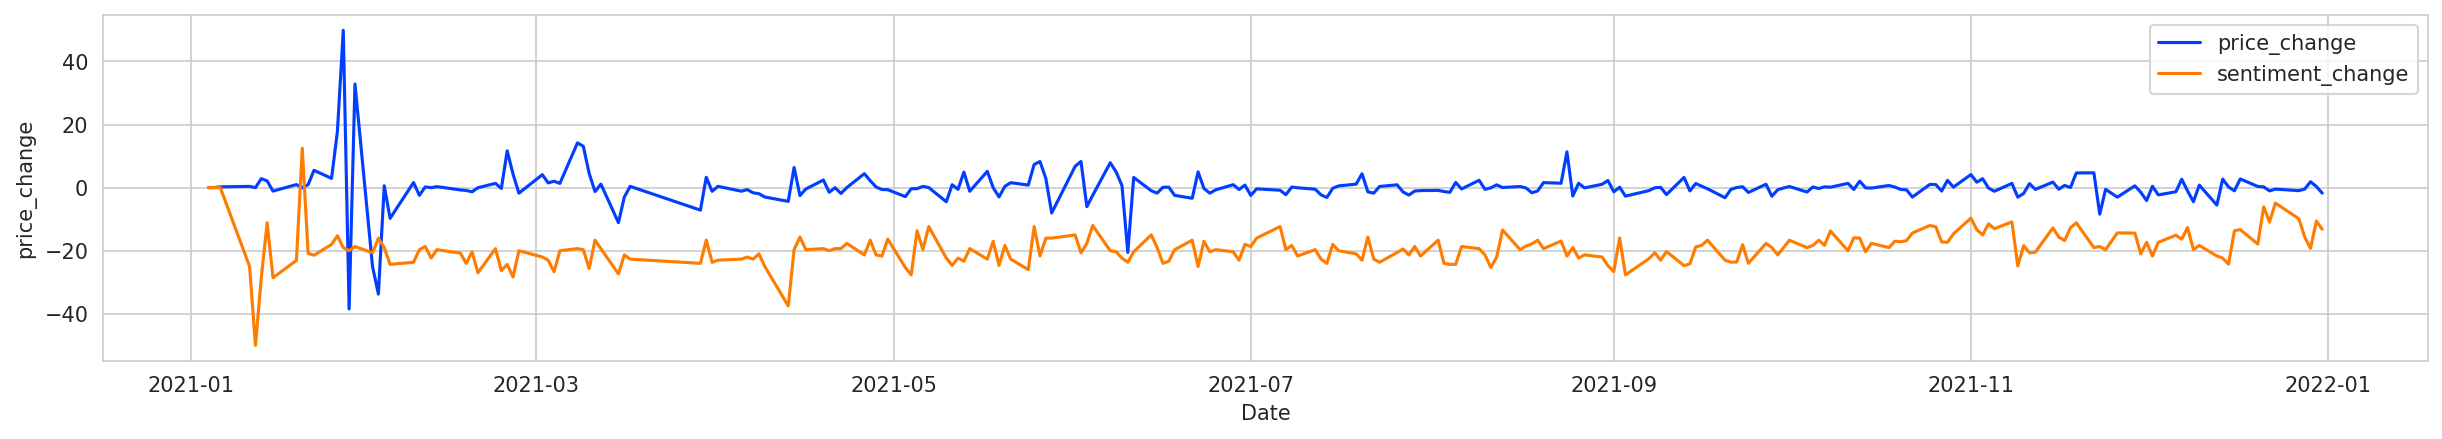

In [26]:
plt.figure(figsize=(20,3), dpi=150)
sns.lineplot(dff['price_change'], label ='price_change')
sns.lineplot(dff['sentiment']*100, label = 'sentiment_change')


<Axes: xlabel='Date', ylabel='price_change'>

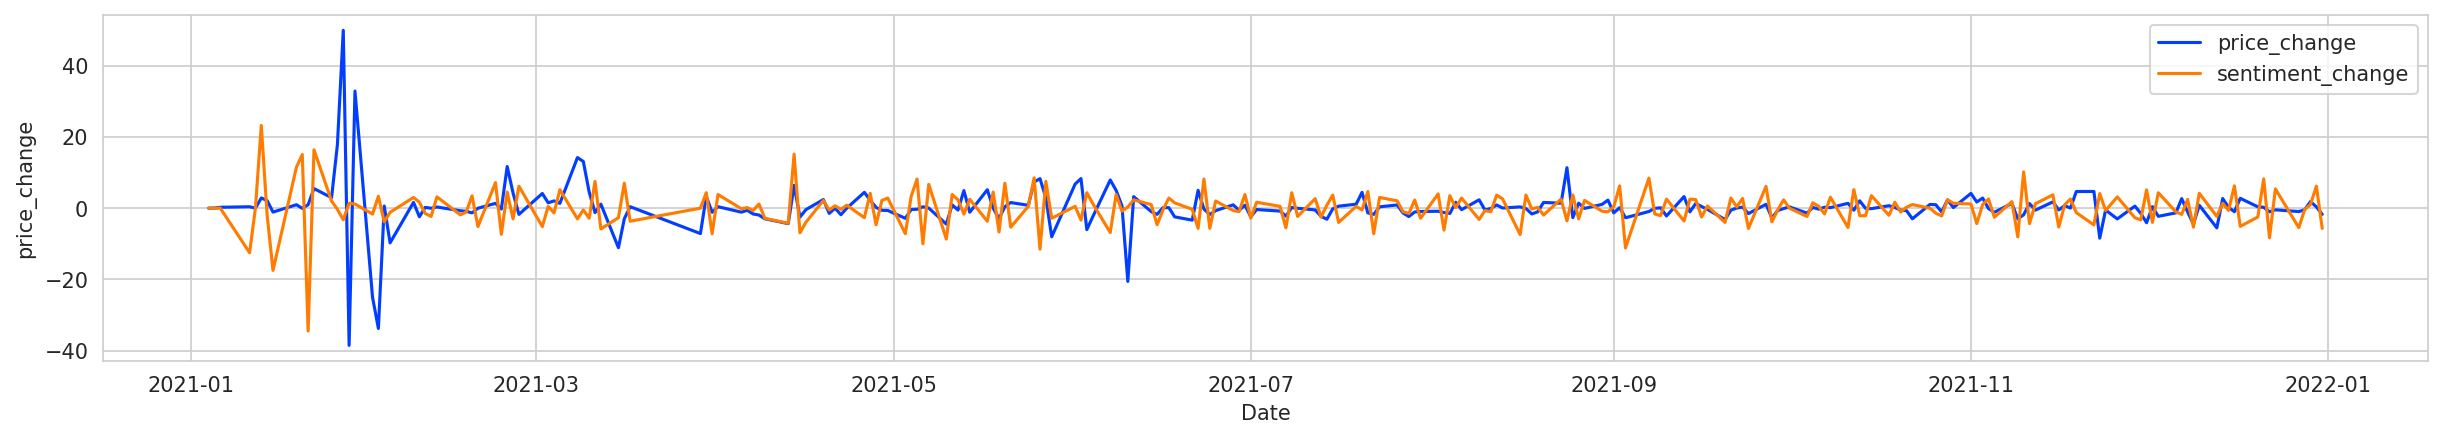

In [27]:
plt.figure(figsize=(20,3), dpi=150)
sns.lineplot(dff['price_change'], label ='price_change')
sns.lineplot(dff['sentiment_change'].diff().fillna(0)*50, label = 'sentiment_change')


<Axes: >

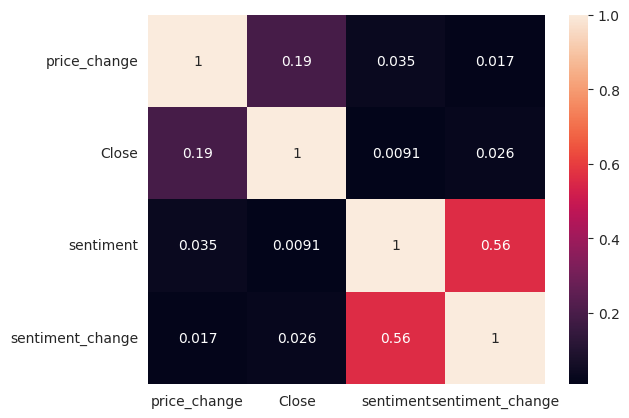

In [28]:
sns.heatmap(dff[['price_change','Close', 'sentiment','sentiment_change']].corr(),annot=True)

**The sentiment analysis our fine-tuned Bert gives does not give a good correlation with price or price change. Therefore we cannot use it to train LSTM. This can be due to several reasons: \
1.Our Bert is fine tuned on kaggle financial news headlines, which is drastically different from our Reddit post, and the model fails to generalize to Reddit post. \
2.Our model mostly outputs sentiment as neutral, if we could have included only positive and negative classes, or simply using the embeddings, it would give us stronger correlation with the stock price.\
But it serves as a good baseline methods, we'll train LSTM with sentiment labels first, and then explore Tf-idf embeddings, finally explore bert embeddings.**


# **Train with Baseline: with sentiment labels**

In [29]:
df_ts = dff[['Close', 'High', 'Low', 'Open', 'Volume','sentiment']]
df_ts['Date']= dff.index
df_ts['Date'] = pd.to_datetime(df_ts['Date'])
df_ts.index = df_ts['Date']
df_ts=df_ts.drop(columns=['Date'])

<ipython-input-29-0e534ff44ac9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ts['Date']= dff.index
<ipython-input-29-0e534ff44ac9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ts['Date'] = pd.to_datetime(df_ts['Date'])


### **Train Test Split**

In [30]:
total_len = len(df_ts)

train = df_ts[df_ts.index<pd.to_datetime("2021-05-01")]
val   = df_ts[(df_ts.index < pd.to_datetime("2021-06-01")) & (df_ts.index > pd.to_datetime("2021-05-01"))]
test  = df_ts[(df_ts.index < pd.to_datetime("2021-09-01")) & (df_ts.index > pd.to_datetime("2021-05-31"))]
print("train_len",len(train)/total_len,"val_len", len(val)/total_len,"test_len", len(test)/total_len)

train_len 0.2916666666666667 val_len 0.08333333333333333 test_len 0.2708333333333333


In [31]:
X_train = np.array(train.values)
X_val = np.array(val.values)
X_test = np.array(test.values)
factor_name = train.columns
print(factor_name)
X_train.shape, X_val.shape, X_test.shape


Index(['Close', 'High', 'Low', 'Open', 'Volume', 'sentiment'], dtype='object')


((70, 6), (20, 6), (65, 6))

In [32]:
train_mean = np.mean(X_train, axis=0, keepdims = True)
train_std = np.std(X_train, axis=0, keepdims = True)

### **Dataset & DataLoader**

In [33]:
class TSDataset(torch.utils.data.Dataset):
    def __init__(self, data, indices, seq_len, pred_len=20) :
        super().__init__()
        self.data = (data-torch.FloatTensor(train_mean))/torch.FloatTensor(train_std)
        self.indices = indices
        self.seq_len = seq_len
        self.pred_len= pred_len

    def __len__(self):
        return len(self.indices)

    def get_sequence(self, sequence, seq_len) :

        x = sequence[0:-self.pred_len,:]     #0~7 close open high low volume
        y = sequence[self.pred_len:,0]     #8 close

        return x, y

    def __getitem__(self, index):
        start, end = self.indices[index]
        sequence = self.data[start:end]
        x, y = self.get_sequence(sequence, self.seq_len)

        return x, y

def get_windows(data, window_size, step_size=1):
    # Start the first sub-sequence at index position 0
    start = 0
    end = window_size

    indices = []
    while end <= len(data)-1:      #proceed window by step size, count how many sequences
        indices.append((start, end))
        start += step_size
        end += step_size
    return indices

[(0, 6), (1, 7), (2, 8), (3, 9), (4, 10), (5, 11), (6, 12), (7, 13), (8, 14), (9, 15), (10, 16), (11, 17), (12, 18), (13, 19), (14, 20), (15, 21), (16, 22), (17, 23), (18, 24), (19, 25), (20, 26), (21, 27), (22, 28), (23, 29), (24, 30), (25, 31), (26, 32), (27, 33), (28, 34), (29, 35), (30, 36), (31, 37), (32, 38), (33, 39), (34, 40), (35, 41), (36, 42), (37, 43), (38, 44), (39, 45), (40, 46), (41, 47), (42, 48), (43, 49), (44, 50), (45, 51), (46, 52), (47, 53), (48, 54), (49, 55), (50, 56), (51, 57), (52, 58), (53, 59), (54, 60), (55, 61), (56, 62), (57, 63), (58, 64), (59, 65), (60, 66), (61, 67), (62, 68), (63, 69)]
torch.Size([64, 5]) torch.Size([64, 5, 6])
x:  tensor([0.9949, 1.0157, 0.6550, 0.8215, 0.7628])
y_train:  tensor([1.0157, 0.6550, 0.8215, 0.7628, 0.7834])


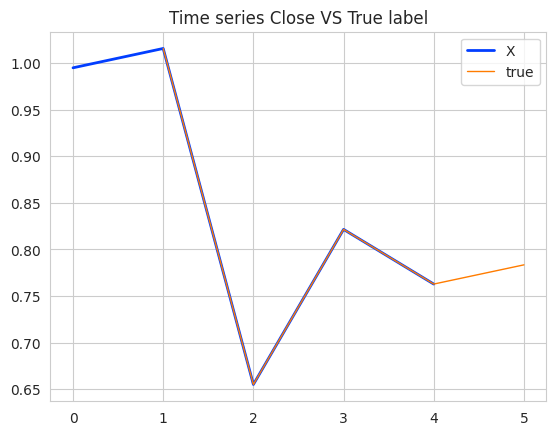

In [34]:
config = {
  'batch_size': 64,
  'lr':2e-3,
  'epochs': 30,
}
#TODO: tune context_len and pred_len
context_len=5
pred_len=1
window_len=context_len+pred_len
training_indices = get_windows(X_train, window_len, step_size=1) #TODO: Tune step size...
val_indices = get_windows(X_val,window_len, step_size=1) #TODO: Tune step size...
test_indices = get_windows(X_test, window_len, step_size=pred_len)

print(training_indices)
train_data=TSDataset(torch.FloatTensor(X_train), training_indices, window_len, pred_len=pred_len)
val_data=TSDataset(torch.FloatTensor(X_val), val_indices, window_len, pred_len=pred_len)
test_data=TSDataset(torch.FloatTensor(X_test), test_indices, window_len, pred_len=pred_len)

train_loader = torch.utils.data.DataLoader(
    dataset     = train_data,
    batch_size  = config['batch_size'],
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset     = val_data,
    batch_size  = 24,
    shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    dataset     = test_data,
    batch_size  = 24,
    pin_memory  = False,
    shuffle=False
)

for batch in train_loader:
    x, y_train=batch
    print(y_train.shape, x.shape)
    print("x: ", x[0,:,0]) #0 is the closing price
    print("y_train: ", y_train[0,:])  #True label should shift by one to right
    plt.plot(x[0,:,0], linewidth=2, label ="X")
    plt.plot(np.arange(pred_len, window_len), y_train[0,:], linewidth=1, label ="true")
    plt.legend()
    plt.title("Time series Close VS True label")
    break

### **LSTM Model**

In [35]:
class LSTM_Block(nn.Module):
  def __init__(self, input_dim, output_dim, dropout=0.3):
    super(LSTM_Block, self).__init__()
    self.lstm = nn.LSTM(input_dim, output_dim, num_layers=1, dropout=dropout, bias=True, batch_first=True)
    # self.bn= nn.BatchNorm1d(output_dim)
    self.dp = nn.Dropout(dropout)
    # self.act = nn.LeakyReLU()
  def forward(self, x):
    out,_ = self.lstm(x)
    # out = self.bn(out.permute(0,2,1)).permute(0,2,1)
    out = self.dp(out)
    # out = self.act(out)
    return out

class LSTM(nn.Module):
    def __init__(self, input_dim, output_dim, d_model=512, dropout=0.3):
        super(LSTM, self).__init__()
        self.d_model=d_model
        self.model = torch.nn.Sequential(

            LSTM_Block(input_dim, d_model),
            LSTM_Block(d_model, d_model),
            nn.Linear(d_model,d_model),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model,output_dim)
        )


    def forward(self, x):
        return self.model(x)

In [36]:
#TODO: tune model parameters
model=LSTM(input_dim=X_train.shape[-1], output_dim=1, d_model=512, dropout=0.5).to(device)
# print(x.size)
for x, y in train_loader:
    x=torch.FloatTensor(x).to(device)
    y=torch.FloatTensor(y).to(device)
    print(x[0,:,0], y[0])
    print("x shape:",x.shape, "y shape:", y.shape)
    out=model(x)
    print("out shape:", out.shape)
    summary(model,x)
    break

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


tensor([0.4408, 0.3669, 0.3667, 0.2738, 0.2739], device='cuda:0') tensor([0.3669, 0.3667, 0.2738, 0.2739, 0.4985], device='cuda:0')
x shape: torch.Size([64, 5, 6]) y shape: torch.Size([64, 5])
out shape: torch.Size([64, 5, 1])
                     Kernel Shape  Output Shape     Params  Mult-Adds
Layer                                                                
0_model.0.LSTM_lstm             -  [64, 5, 512]   1.06496M  1.060864M
1_model.0.Dropout_dp            -  [64, 5, 512]          -          -
2_model.1.LSTM_lstm             -  [64, 5, 512]  2.101248M  2.097152M
3_model.1.Dropout_dp            -  [64, 5, 512]          -          -
4_model.Linear_2       [512, 512]  [64, 5, 512]   262.656k   262.144k
5_model.LeakyReLU_3             -  [64, 5, 512]          -          -
6_model.Dropout_4               -  [64, 5, 512]          -          -
7_model.Linear_5         [512, 1]    [64, 5, 1]      513.0      512.0
---------------------------------------------------------------------
   

/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


In [37]:
optimizer   = torch.optim.AdamW(model.parameters(), lr= config['lr'], weight_decay = 0.001)
criterion   = torch.nn.MSELoss()
scaler      = torch.cuda.amp.GradScaler()
scheduler   = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)
# Optional (but Recommended): Create a custom class for a Teacher Force Schedule

In [38]:
def train():
      model.train() # set to training mode
      model.to(device)

      batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      running_loss        = 0.0

      for i, batch in enumerate(train_loader):
          optimizer.zero_grad()

          x, y_train = batch

          x = x.to(device)
          y_train = y_train.to(device)
          y_pred = model(x)

          loss = criterion(y_pred[:,-pred_len:], y_train.unsqueeze(-1)[:,-pred_len:])   #TODO: try changing 8 to others, if want the model to learn other columns
          loss.backward()
          optimizer.step()

          # train_plot.append(loss.item())
          running_loss += loss.item()

          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1)),
              lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])),
              # teacher_time="{:.04f}".format(teach/10)
               )
          batch_bar.update()

          del x, y_train, y_pred
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(train_loader)

def validate():
      model.eval() # set to training mode
      model.to(device)

      batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      running_loss        = 0.0

      for i, batch in enumerate(val_loader):
          optimizer.zero_grad()
          x, y_test = batch

          x = x.to(device)
          y_test = y_test.to(device)

          y_pred = model(x)
          val_loss = criterion(y_pred[:,-pred_len:], y_test.unsqueeze(-1)[:,-pred_len:])    #TODO: try changing 8 to others, if want the model to learn other columns

          running_loss += val_loss.item()

          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1))
               )
          batch_bar.update()

          del x, y_test
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(val_loader)

def test(test_loader):
        model.eval() # set to training mode
        model.to(device)
        batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
        prediction=[]
        true_labels = []
        for i, batch in enumerate(test_loader):
            optimizer.zero_grad()
            x, y_test = batch
            x = x.to(device)

            y_pred = model(x)[:,:,0] #take tomorrow
            prediction.append(y_pred[:,-pred_len:].cpu().detach().numpy())
            true_labels.append(y_test[:,-pred_len:].cpu().detach().numpy())

            del x, y_test
            torch.cuda.empty_cache()
            batch_bar.update()

        batch_bar.close()


        return np.concatenate(prediction)*train_std[0][0]+train_mean[0][0], \
               np.concatenate(true_labels)*train_std[0][0]+train_mean[0][0]

### **Train Loop**

In [39]:
# optimizer.param_groups[0]['lr']=1e-4
train_loss_plot=[]
val_loss_plot=[]
num_epochs=50
for epoch in range(0, num_epochs):

    # Call train and validate
    print("\nEpoch: {}/{}".format(epoch+1, num_epochs))

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_loss              = train()
    train_loss_plot.append(train_loss)

    val_loss              = validate()
    val_loss_plot.append(val_loss)

    # trainer.teacher_forcing_ratio=max(trainer.teacher_forcing_ratio-0.05,0.1)
    scheduler.step()

    print("\tTrain Loss {:.04f}\t Learning Rate {:.07f}\t Validation Loss {:.04f}".format(train_loss, curr_lr, val_loss))



Epoch: 1/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.9417	 Learning Rate 0.0020000	 Validation Loss 0.5131

Epoch: 2/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.8602	 Learning Rate 0.0016000	 Validation Loss 0.3880

Epoch: 3/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.6971	 Learning Rate 0.0012800	 Validation Loss 0.2319

Epoch: 4/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.5956	 Learning Rate 0.0010240	 Validation Loss 0.1692

Epoch: 5/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.5736	 Learning Rate 0.0008192	 Validation Loss 0.1736

Epoch: 6/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.5079	 Learning Rate 0.0006554	 Validation Loss 0.1876

Epoch: 7/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.4705	 Learning Rate 0.0005243	 Validation Loss 0.2002

Epoch: 8/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.4381	 Learning Rate 0.0004194	 Validation Loss 0.2081

Epoch: 9/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.4413	 Learning Rate 0.0003355	 Validation Loss 0.2126

Epoch: 10/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.4121	 Learning Rate 0.0002684	 Validation Loss 0.2132

Epoch: 11/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.4217	 Learning Rate 0.0002147	 Validation Loss 0.2119

Epoch: 12/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3935	 Learning Rate 0.0001718	 Validation Loss 0.2092

Epoch: 13/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3987	 Learning Rate 0.0001374	 Validation Loss 0.2061

Epoch: 14/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3808	 Learning Rate 0.0001100	 Validation Loss 0.2028

Epoch: 15/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.4105	 Learning Rate 0.0000880	 Validation Loss 0.1998

Epoch: 16/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3903	 Learning Rate 0.0000704	 Validation Loss 0.1971

Epoch: 17/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3861	 Learning Rate 0.0000563	 Validation Loss 0.1948

Epoch: 18/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3834	 Learning Rate 0.0000450	 Validation Loss 0.1930

Epoch: 19/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3853	 Learning Rate 0.0000360	 Validation Loss 0.1915

Epoch: 20/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3760	 Learning Rate 0.0000288	 Validation Loss 0.1902

Epoch: 21/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3797	 Learning Rate 0.0000231	 Validation Loss 0.1892

Epoch: 22/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3818	 Learning Rate 0.0000184	 Validation Loss 0.1884

Epoch: 23/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3888	 Learning Rate 0.0000148	 Validation Loss 0.1878

Epoch: 24/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.4012	 Learning Rate 0.0000118	 Validation Loss 0.1873

Epoch: 25/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3687	 Learning Rate 0.0000094	 Validation Loss 0.1869

Epoch: 26/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3879	 Learning Rate 0.0000076	 Validation Loss 0.1866

Epoch: 27/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3762	 Learning Rate 0.0000060	 Validation Loss 0.1864

Epoch: 28/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3812	 Learning Rate 0.0000048	 Validation Loss 0.1862

Epoch: 29/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3739	 Learning Rate 0.0000039	 Validation Loss 0.1861

Epoch: 30/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3700	 Learning Rate 0.0000031	 Validation Loss 0.1860

Epoch: 31/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3879	 Learning Rate 0.0000025	 Validation Loss 0.1859

Epoch: 32/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3626	 Learning Rate 0.0000020	 Validation Loss 0.1858

Epoch: 33/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3664	 Learning Rate 0.0000016	 Validation Loss 0.1858

Epoch: 34/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3815	 Learning Rate 0.0000013	 Validation Loss 0.1857

Epoch: 35/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3702	 Learning Rate 0.0000010	 Validation Loss 0.1857

Epoch: 36/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3739	 Learning Rate 0.0000008	 Validation Loss 0.1856

Epoch: 37/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3786	 Learning Rate 0.0000006	 Validation Loss 0.1856

Epoch: 38/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3848	 Learning Rate 0.0000005	 Validation Loss 0.1856

Epoch: 39/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3713	 Learning Rate 0.0000004	 Validation Loss 0.1856

Epoch: 40/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3853	 Learning Rate 0.0000003	 Validation Loss 0.1856

Epoch: 41/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3744	 Learning Rate 0.0000003	 Validation Loss 0.1856

Epoch: 42/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3781	 Learning Rate 0.0000002	 Validation Loss 0.1856

Epoch: 43/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3708	 Learning Rate 0.0000002	 Validation Loss 0.1856

Epoch: 44/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3743	 Learning Rate 0.0000001	 Validation Loss 0.1856

Epoch: 45/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3581	 Learning Rate 0.0000001	 Validation Loss 0.1856

Epoch: 46/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3769	 Learning Rate 0.0000001	 Validation Loss 0.1855

Epoch: 47/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3691	 Learning Rate 0.0000001	 Validation Loss 0.1855

Epoch: 48/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3739	 Learning Rate 0.0000001	 Validation Loss 0.1855

Epoch: 49/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3641	 Learning Rate 0.0000000	 Validation Loss 0.1855

Epoch: 50/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3700	 Learning Rate 0.0000000	 Validation Loss 0.1855


Text(0.5, 1.0, 'Validation loss')

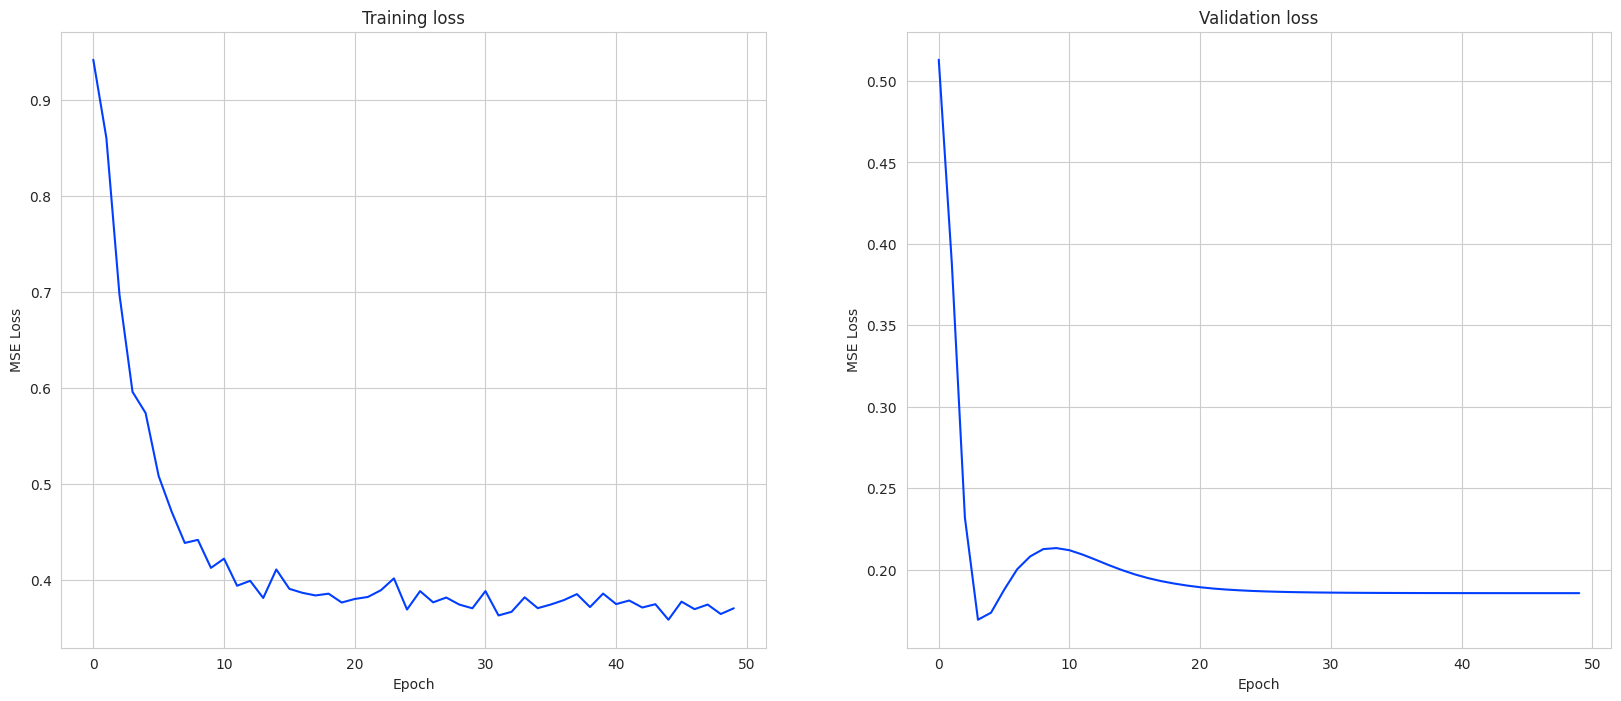

In [40]:
fig, ax=plt.subplots(1,2, figsize=(20,8))
# ax[0].plot(trainer.train_plot)
ax[0].plot(train_loss_plot)
ax[0].set_ylabel("MSE Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Training loss")

ax[1].plot(val_loss_plot)
ax[1].set_ylabel("MSE Loss")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Validation loss")


### **Evaluate and Inference**

In [41]:
prediction,true_labels=test(test_loader)
prediction = prediction.reshape(-1)
true_labels = true_labels.reshape(-1)
print(prediction.shape, true_labels.shape)
baseline_test_metrics = get_metrics(prediction,true_labels)
baseline_test_metrics

Train:   0%|          | 0/3 [00:00<?, ?it/s]

(59,) (59,)


MSE      RMSE       MAE      MAPE  Serial Corr  Pearson Corr(IC),  \
0  69.992683  8.366163  5.953912  0.136495     0.871836          -0.179569   

   Spearman Corr(IC)  
0           -0.09013

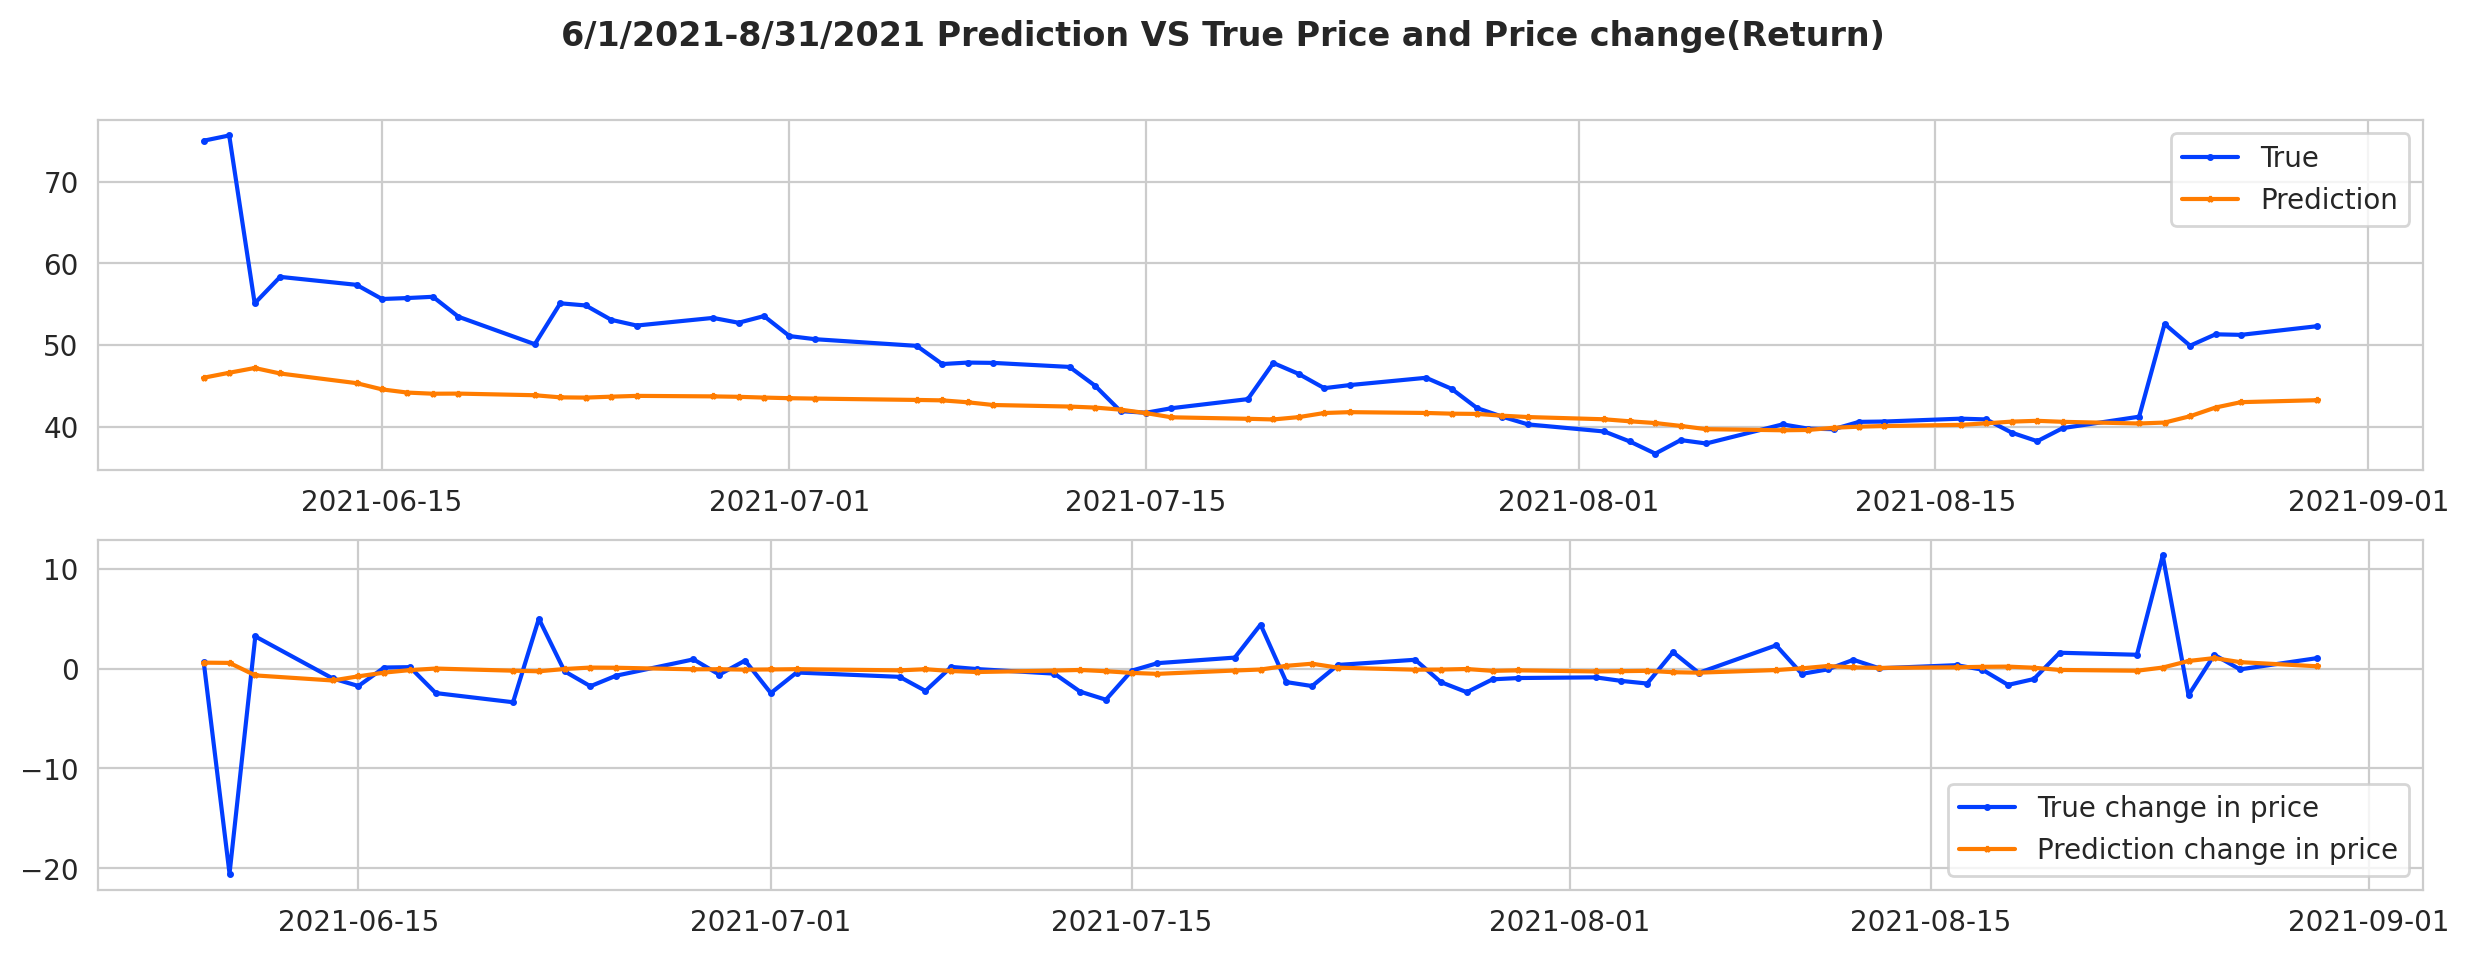

In [42]:
fig,ax=plt.subplots(2,1, figsize=(15,5),dpi=200)
date = df_ts[(df_ts.index>=pd.to_datetime("2021-06-08")) & (df_ts.index<=pd.to_datetime("2021-08-30"))].reset_index()['Date']
ax[0].plot(date, true_labels, label='True', marker='.', markersize=3)
ax[0].plot(date, prediction, label='Prediction',marker='*', markersize=2)
ax[0].legend()

ax[1].plot(date[1:], np.diff(true_labels), label='True change in price', marker='.', markersize=3)
ax[1].plot(date[1:],np.diff(prediction), label='Prediction change in price',marker='*', markersize=2)
ax[1].legend()
fig.suptitle("6/1/2021-8/31/2021 Prediction VS True Price and Price change(Return)", fontweight="bold")
plt.show()

In [43]:
inference_indices = get_windows(df_ts[df_ts.index<pd.to_datetime('2021-09-01')], window_len, step_size=pred_len)

inference_data=TSDataset(torch.FloatTensor(np.array(df_ts[df_ts.index<pd.to_datetime('2021-09-01')].values)), inference_indices, window_len, pred_len=pred_len)

inference_loader = torch.utils.data.DataLoader(
    dataset     = inference_data,
    batch_size  = len(inference_data),
    pin_memory  = False,
    shuffle=False
)
# inference_indices

In [44]:
prediction,true_labels=test(inference_loader)
# prediction = prediction[:,0]
# true_labels=true_labels[:,0]
prediction = prediction.reshape(-1)
true_labels = true_labels.reshape(-1)
print(prediction.shape, true_labels.shape)
baseline_train_test_metrics = get_metrics(prediction,true_labels)
baseline_train_test_metrics

Train:   0%|          | 0/1 [00:00<?, ?it/s]

(149,) (149,)


MSE       RMSE       MAE     MAPE  Serial Corr  Pearson Corr(IC),  \
0  110.846237  10.528354  7.139283  0.20296     0.790298            0.19304   

   Spearman Corr(IC)  
0            0.10905

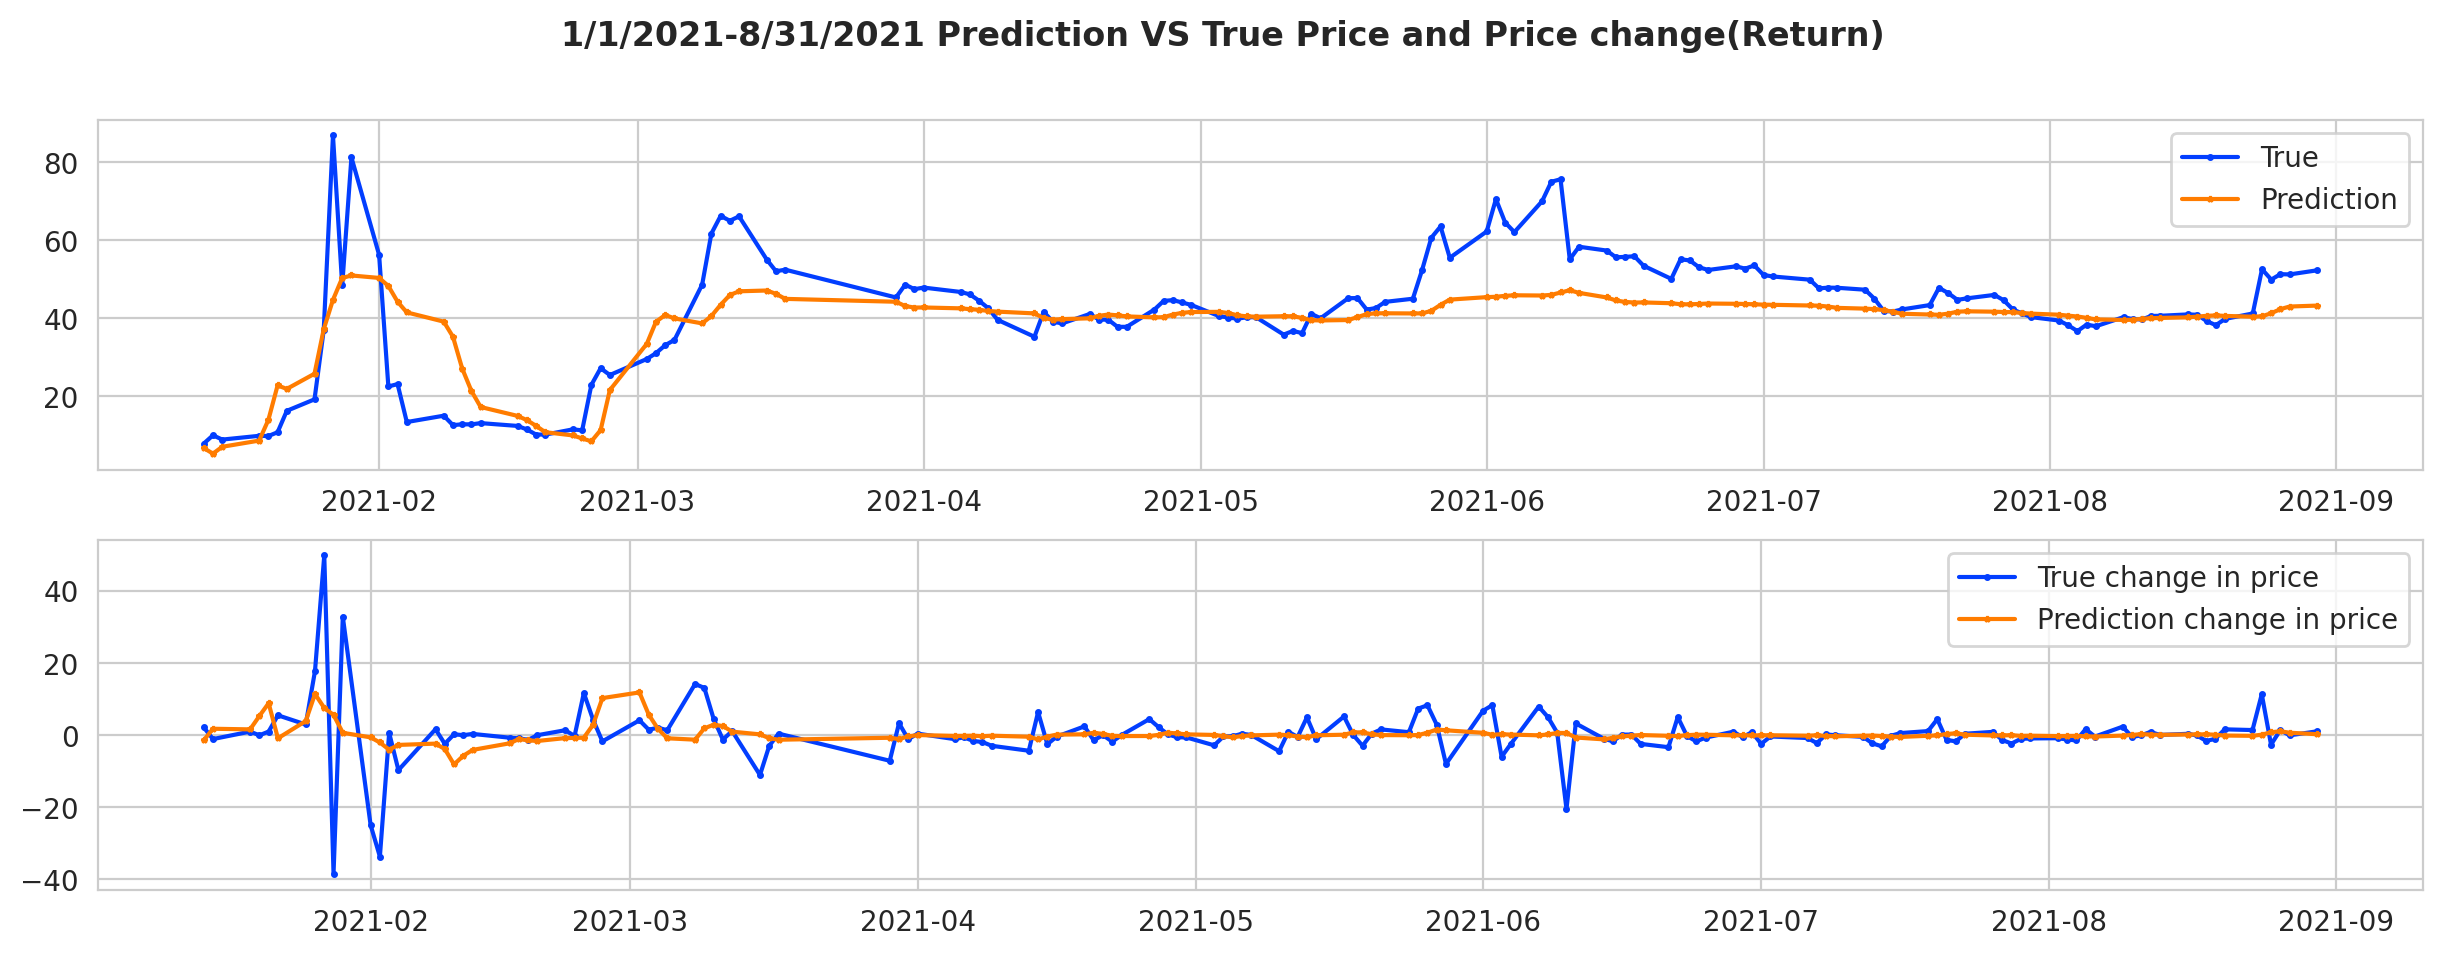

In [45]:
fig,ax=plt.subplots(2,1, figsize=(15,5),dpi=200)
date = df_ts[(df_ts.index>=pd.to_datetime("2021-01-13")) & (df_ts.index<=pd.to_datetime("2021-08-30"))].reset_index()['Date']
ax[0].plot(date,true_labels, label='True', marker='.', markersize=3)
ax[0].plot(date,prediction, label='Prediction',marker='*', markersize=2)
ax[0].legend()

ax[1].plot(date[1:],np.diff(true_labels), label='True change in price', marker='.', markersize=3)
ax[1].plot(date[1:], np.diff(prediction), label='Prediction change in price',marker='*', markersize=2)
ax[1].legend()
fig.suptitle("1/1/2021-8/31/2021 Prediction VS True Price and Price change(Return)", fontweight="bold")
plt.show()

# **Explore TF-IDF**

In [46]:
#combine Reddit titles each day to calculate TF-IDF, each day, we only take the first 10k words
df_comb_titles = df[['title','Date']].groupby('Date')['title'].apply('. '.join)
df_comb_titles  = pd.DataFrame(df_comb_titles)
df_comb_titles['title'] = df_comb_titles['title'].apply(lambda x:x[:10000])
df_comb_titles

title
Date                                                         
2021-01-04  short squeeze incoming  rocket  rocket  rocket...
2021-01-05  this convinced me to all in  money_bag gme ext...
2021-01-06  icr conference 11th jan. hey guys we have a fr...
2021-01-11  ryan cohen not being paid. buckle your seatbel...
2021-01-12  questions from a potential investor about game...
...                                                       ...
2021-12-27  ryan cohen on twitter.  rocket  rocket  we had...
2021-12-28  right clicking all the nfts. throw the book at...
2021-12-29  so banks charge overdraft fees when you dont h...
2021-12-30  gamestop is doing something much bigger than j...
2021-12-31  happy new year apes painting by me spot the ea...

[240 rows x 1 columns]

In [47]:
df_comb_titles['title'].apply(lambda x:len(x)).describe()

count      240.000000
mean      9492.133333
std       2084.785844
min        109.000000
25%      10000.000000
50%      10000.000000
75%      10000.000000
max      10000.000000
Name: title, dtype: float64

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(token_pattern=r'(?u)\b[A-Za-z]+\b')
tfidf_matrix = vectorizer.fit_transform(list(df_comb_titles['title']))
print("TF-IDF shape: ",tfidf_matrix.shape)

dense_matrix = tfidf_matrix.todense()
df_tfidf = pd.DataFrame(dense_matrix, columns=vectorizer.get_feature_names_out())
df_tfidf

TF-IDF shape:  (240, 18963)


a   aa  aaa  aaaaaaaaand  aaaaaaaand  aaaaaah  aaaaaand  aaaaaaw  \
0    0.000000  0.0  0.0          0.0         0.0      0.0       0.0      0.0   
1    0.091917  0.0  0.0          0.0         0.0      0.0       0.0      0.0   
2    0.094130  0.0  0.0          0.0         0.0      0.0       0.0      0.0   
3    0.000000  0.0  0.0          0.0         0.0      0.0       0.0      0.0   
4    0.101488  0.0  0.0          0.0         0.0      0.0       0.0      0.0   
..        ...  ...  ...          ...         ...      ...       ...      ...   
235  0.146016  0.0  0.0          0.0         0.0      0.0       0.0      0.0   
236  0.123268  0.0  0.0          0.0         0.0      0.0       0.0      0.0   
237  0.147930  0.0  0.0          0.0         0.0      0.0       0.0      0.0   
238  0.115883  0.0  0.0          0.0         0.0      0.0       0.0      0.0   
239  0.167895  0.0  0.0          0.0         0.0      0.0       0.0      0.0   

     aaaaand  aaaaannnnddd  ...  zoos  zuck  zum  zur  zusammen  zwebsites  \
0        0.0           0.0  ...   0.0   0.0  0.0  0.0       0.0        0.0   
1        0.0           0.0  ...   0.0   0.0  0.0  0.0       0.0        0.0   
2        0.0           0.0  ...   0.0   0.0  0.0  0.0       0.0        0.0   
3        0.0           0.0  ...   0.0   0.0  0.0  0.0       0.0        0.0   
4        0.0           0.0  ...   0.0   0.0  0.0  0.0       0.0        0.0   
..       ...           ...  ...   ...   ...  ...  ...       ...        ...   
235      0.0           0.0  ...   0.0   0.0  0.0  0.0       0.0        0.0   
236      0.0           0.0  ...   0.0   0.0  0.0  0.0       0.0        0.0   
237      0.0           0.0  ...   0.0   0.0  0.0  0.0       0.0        0.0   
238      0.0           0.0  ...   0.0   0.0  0.0  0.0       0.0        0.0   
239      0.0           0.0  ...   0.0   0.0  0.0  0.0       0.0        0.0   

     zwiss  zzz  zzzzz  zzzzzap  
0      0.0  0.0    0.0      0.0  
1      0.0  0.0    0.0      0.0  
2      0.0  0.0    0.0      0.0  
3      0.0  0.0    0.0      0.0  
4      0.0  0.0    0.0      0.0  
..     ...  ...    ...      ...  
235    0.0  0.0    0.0      0.0  
236    0.0  0.0    0.0      0.0  
237    0.0  0.0    0.0      0.0  
238    0.0  0.0    0.0      0.0  
239    0.0  0.0    0.0      0.0  

[240 rows x 18963 columns]

In [49]:
dff = df[df.columns.difference(['title'])].groupby('Date').mean()
dff['price_change'] = dff['Close'].diff().fillna(0)

## **PCA from 19k+dims to 200 dims**

In [50]:
from sklearn.decomposition import PCA
n_comp = 200
pca = PCA(n_components=n_comp)
pca_result = pca.fit_transform(np.array(dense_matrix))

explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratio:", explained_variance_ratio.sum())

# If you want to examine the PCA result as a DataFrame
df_pca = pd.DataFrame(pca_result,columns=['pc'+str(i) for i in range(n_comp)])
df_pca.index = dff.index
df_pca

Explained variance ratio: 0.911286267519826


pc0       pc1       pc2       pc3       pc4       pc5  \
Date                                                                     
2021-01-04  0.734924  0.358011  0.489215 -0.256846 -0.067637 -0.064657   
2021-01-05  0.219657  0.505958 -0.288789  0.087292 -0.400175  0.026787   
2021-01-06  0.288233  0.602801 -0.331748  0.032189 -0.172912 -0.066857   
2021-01-11  0.392965  0.552735 -0.105582 -0.278948  0.119211  0.089156   
2021-01-12  0.160959  0.470379 -0.305107 -0.264718  0.511805  0.261720   
...              ...       ...       ...       ...       ...       ...   
2021-12-27 -0.088640  0.042664  0.082956 -0.076859  0.017115 -0.023063   
2021-12-28 -0.153843  0.027934  0.050092 -0.008690  0.035843  0.037561   
2021-12-29 -0.222646  0.058051  0.019147  0.033223  0.019859  0.008022   
2021-12-30 -0.097985  0.067847  0.033534 -0.005448 -0.070980 -0.026381   
2021-12-31 -0.111370  0.008969 -0.045561 -0.021033  0.042208 -0.006071   

                 pc6       pc7       pc8       pc9  ...     pc190     pc191  \
Date                                                ...                       
2021-01-04 -0.053298 -0.009358  0.021428 -0.016688  ... -0.021844  0.020174   
2021-01-05  0.087822 -0.163168 -0.116555 -0.224399  ...  0.000734 -0.000092   
2021-01-06  0.247203 -0.492848  0.524746 -0.103760  ...  0.003663 -0.004252   
2021-01-11  0.038221 -0.209434 -0.370589  0.097674  ... -0.012413 -0.005651   
2021-01-12  0.108820 -0.101463 -0.066646  0.066920  ... -0.011197 -0.002981   
...              ...       ...       ...       ...  ...       ...       ...   
2021-12-27  0.085794  0.052937 -0.061395  0.031212  ... -0.027697 -0.034864   
2021-12-28  0.094132  0.045172 -0.030925 -0.032408  ... -0.008601  0.015263   
2021-12-29  0.088363  0.008414 -0.026784 -0.008543  ...  0.007591 -0.010118   
2021-12-30  0.045023  0.013134 -0.071532 -0.023241  ...  0.055431 -0.027799   
2021-12-31  0.140924  0.072974 -0.016834  0.004101  ...  0.004844  0.041794   

               pc192     pc193     pc194     pc195     pc196     pc197  \
Date                                                                     
2021-01-04 -0.004602 -0.013274  0.025732  0.024939 -0.002808 -0.010255   
2021-01-05 -0.000494  0.005036  0.001626  0.001837 -0.000600  0.002021   
2021-01-06 -0.004953 -0.002614  0.002369  0.004578  0.001377 -0.004477   
2021-01-11  0.003228 -0.012230  0.002033 -0.007786 -0.002677  0.000737   
2021-01-12  0.001346  0.014367 -0.010468 -0.004589  0.007822  0.000981   
...              ...       ...       ...       ...       ...       ...   
2021-12-27 -0.026177  0.005266  0.024674 -0.005148 -0.034356 -0.053847   
2021-12-28  0.030443  0.034288  0.048872 -0.056486  0.019876  0.047829   
2021-12-29  0.059553 -0.027437  0.086187 -0.064346  0.043214 -0.007882   
2021-12-30 -0.038149  0.003727 -0.019215  0.034696 -0.007906  0.003779   
2021-12-31  0.012573 -0.021879 -0.051834  0.042794 -0.008898  0.028455   

               pc198     pc199  
Date                            
2021-01-04 -0.012662  0.007067  
2021-01-05  0.000318 -0.010249  
2021-01-06 -0.004522 -0.004199  
2021-01-11 -0.006772 -0.002187  
2021-01-12 -0.000209  0.000375  
...              ...       ...  
2021-12-27  0.055907  0.014018  
2021-12-28  0.031729 -0.078417  
2021-12-29 -0.060751  0.060314  
2021-12-30 -0.047524  0.027201  
2021-12-31 -0.006568 -0.040222  

[240 rows x 200 columns]

In [51]:
df_full = pd.concat([dff,df_pca],axis=1)
df_full

Close       High        Low       Open      Volume  \
Date                                                                 
2021-01-04   4.312500   4.775000   4.287500   4.750000  40090000.0   
2021-01-05   4.342500   4.520000   4.307500   4.337500  19846000.0   
2021-01-06   4.590000   4.745000   4.332500   4.335000  24224800.0   
2021-01-11   4.985000   5.162500   4.752500   4.852500  59632000.0   
2021-01-12   4.987500   5.100000   4.830000   4.990000  28242800.0   
...               ...        ...        ...        ...         ...   
2021-12-27  37.077499  38.154999  35.000000  38.000000   6454400.0   
2021-12-28  36.615002  39.352501  36.602501  36.875000   5324400.0   
2021-12-29  38.482498  38.872501  35.535000  36.962502   8149600.0   
2021-12-30  38.832500  40.000000  37.500000  37.750000   6247600.0   
2021-12-31  37.097500  39.182499  37.025002  38.404999   5576000.0   

            num_comments     score  price_change       pc0       pc1  ...  \
Date                                                                  ...   
2021-01-04      5.000000  1.000000      0.000000  0.734924  0.358011  ...   
2021-01-05      5.000000  1.000000      0.030000  0.219657  0.505958  ...   
2021-01-06     12.500000  1.000000      0.247500  0.288233  0.602801  ...   
2021-01-11      9.500000  1.250000      0.395000  0.392965  0.552735  ...   
2021-01-12     12.000000  1.500000      0.002500  0.160959  0.470379  ...   
...                  ...       ...           ...       ...       ...  ...   
2021-12-27      0.007576  1.007576     -0.957500 -0.088640  0.042664  ...   
2021-12-28      0.010753  1.005376     -0.462498 -0.153843  0.027934  ...   
2021-12-29      0.010695  1.000000      1.867496 -0.222646  0.058051  ...   
2021-12-30      0.005556  1.022222      0.350002 -0.097985  0.067847  ...   
2021-12-31      0.013889  1.013889     -1.735001 -0.111370  0.008969  ...   

               pc190     pc191     pc192     pc193     pc194     pc195  \
Date                                                                     
2021-01-04 -0.021844  0.020174 -0.004602 -0.013274  0.025732  0.024939   
2021-01-05  0.000734 -0.000092 -0.000494  0.005036  0.001626  0.001837   
2021-01-06  0.003663 -0.004252 -0.004953 -0.002614  0.002369  0.004578   
2021-01-11 -0.012413 -0.005651  0.003228 -0.012230  0.002033 -0.007786   
2021-01-12 -0.011197 -0.002981  0.001346  0.014367 -0.010468 -0.004589   
...              ...       ...       ...       ...       ...       ...   
2021-12-27 -0.027697 -0.034864 -0.026177  0.005266  0.024674 -0.005148   
2021-12-28 -0.008601  0.015263  0.030443  0.034288  0.048872 -0.056486   
2021-12-29  0.007591 -0.010118  0.059553 -0.027437  0.086187 -0.064346   
2021-12-30  0.055431 -0.027799 -0.038149  0.003727 -0.019215  0.034696   
2021-12-31  0.004844  0.041794  0.012573 -0.021879 -0.051834  0.042794   

               pc196     pc197     pc198     pc199  
Date                                                
2021-01-04 -0.002808 -0.010255 -0.012662  0.007067  
2021-01-05 -0.000600  0.002021  0.000318 -0.010249  
2021-01-06  0.001377 -0.004477 -0.004522 -0.004199  
2021-01-11 -0.002677  0.000737 -0.006772 -0.002187  
2021-01-12  0.007822  0.000981 -0.000209  0.000375  
...              ...       ...       ...       ...  
2021-12-27 -0.034356 -0.053847  0.055907  0.014018  
2021-12-28  0.019876  0.047829  0.031729 -0.078417  
2021-12-29  0.043214 -0.007882 -0.060751  0.060314  
2021-12-30 -0.007906  0.003779 -0.047524  0.027201  
2021-12-31 -0.008898  0.028455 -0.006568 -0.040222  

[240 rows x 208 columns]

## **Correlation between TF-IDF(PCA) & Price**

<Axes: >

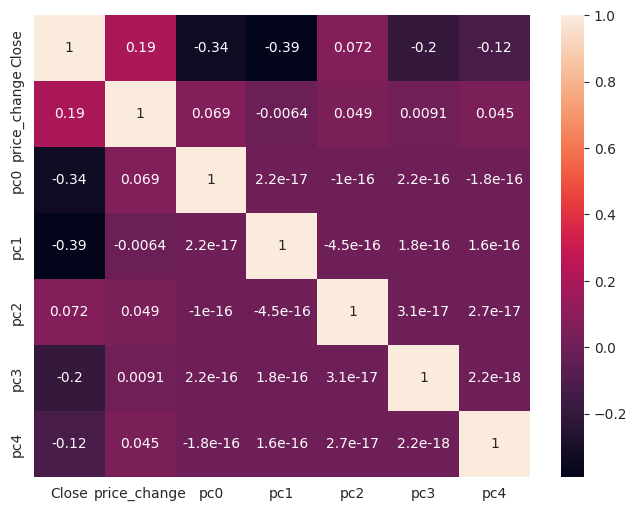

In [52]:
plt.figure(figsize=(8,6),dpi=100)
sns.heatmap(df_full[['Close','price_change','pc0','pc1','pc2','pc3','pc4']].corr(),annot=True,annot_kws={"size":10})

Text(0.5, 1.0, 'GameStop(GME) stock price VS Principal Component')

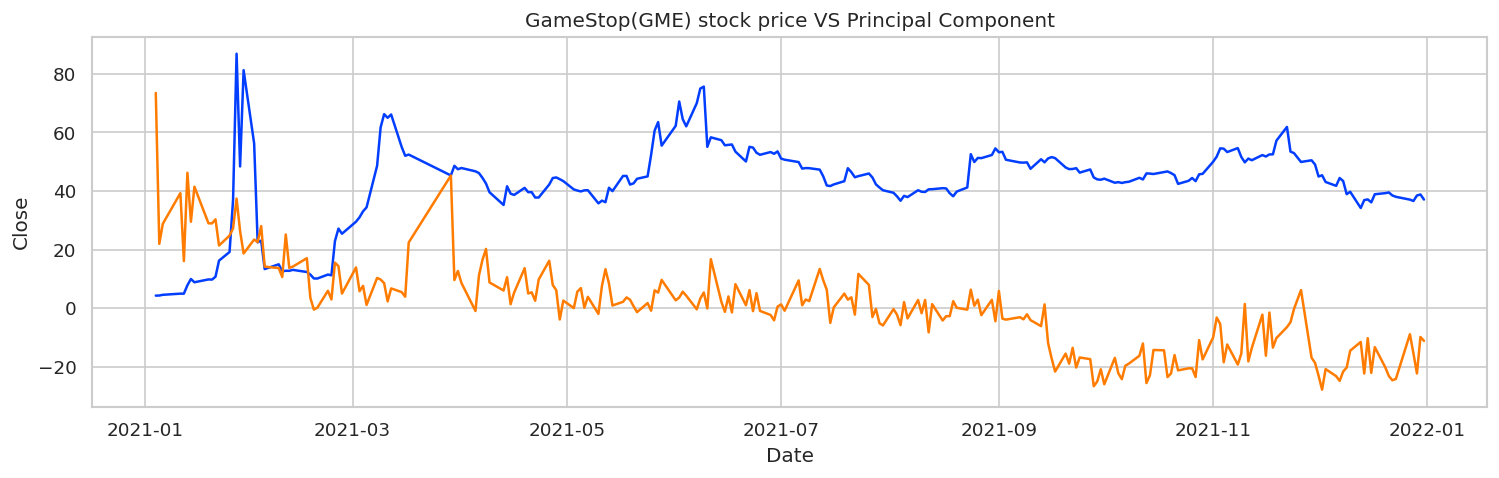

In [53]:
plt.figure(figsize=(15,4),dpi=120)
sns.set(style="whitegrid", palette="bright")
sns.lineplot(df_full['Close'])
sns.lineplot(df_full['pc0']*100)
plt.title("GameStop(GME) stock price VS Principal Component")

## **Time Series with TF-IDF features**

In [54]:
df_ts=df_full.copy().reset_index()
df_ts['Date'] = pd.to_datetime(df_ts['Date'])
df_ts.index = df_ts['Date']
df_ts=df_ts[df_ts.columns.difference(['Date','score','price_change','num_comments','sentiment'])]
df_ts #dimension should be 5(open, high, low, close, volume) +200 =205

Close       High        Low       Open      Volume       pc0  \
Date                                                                           
2021-01-04   4.312500   4.775000   4.287500   4.750000  40090000.0  0.734924   
2021-01-05   4.342500   4.520000   4.307500   4.337500  19846000.0  0.219657   
2021-01-06   4.590000   4.745000   4.332500   4.335000  24224800.0  0.288233   
2021-01-11   4.985000   5.162500   4.752500   4.852500  59632000.0  0.392965   
2021-01-12   4.987500   5.100000   4.830000   4.990000  28242800.0  0.160959   
...               ...        ...        ...        ...         ...       ...   
2021-12-27  37.077499  38.154999  35.000000  38.000000   6454400.0 -0.088640   
2021-12-28  36.615002  39.352501  36.602501  36.875000   5324400.0 -0.153843   
2021-12-29  38.482498  38.872501  35.535000  36.962502   8149600.0 -0.222646   
2021-12-30  38.832500  40.000000  37.500000  37.750000   6247600.0 -0.097985   
2021-12-31  37.097500  39.182499  37.025002  38.404999   5576000.0 -0.111370   

                 pc1      pc10     pc100     pc101  ...      pc90      pc91  \
Date                                                ...                       
2021-01-04  0.358011  0.002517  0.002274  0.008244  ... -0.001431 -0.011542   
2021-01-05  0.505958 -0.458358  0.004966 -0.000418  ... -0.001095  0.003899   
2021-01-06  0.602801  0.348034  0.013699 -0.001263  ... -0.010795  0.000162   
2021-01-11  0.552735 -0.295508 -0.006169  0.003717  ...  0.002970  0.006281   
2021-01-12  0.470379 -0.025736 -0.003463  0.002827  ...  0.005165  0.019845   
...              ...       ...       ...       ...  ...       ...       ...   
2021-12-27  0.042664 -0.009300  0.064248  0.037354  ... -0.044533  0.002249   
2021-12-28  0.027934  0.023280  0.021099  0.075719  ... -0.000650 -0.009592   
2021-12-29  0.058051 -0.000828  0.001824 -0.004531  ...  0.001087 -0.010438   
2021-12-30  0.067847  0.005489 -0.041984 -0.027844  ... -0.053080 -0.026351   
2021-12-31  0.008969  0.017343  0.002534 -0.017121  ...  0.009836  0.012157   

                pc92      pc93      pc94      pc95      pc96      pc97  \
Date                                                                     
2021-01-04 -0.009563  0.005735  0.006654  0.002273  0.013631  0.011386   
2021-01-05  0.002505  0.006324 -0.011793  0.000960  0.011199  0.008182   
2021-01-06  0.019358  0.011724  0.003685  0.009393 -0.005411  0.002052   
2021-01-11  0.001988  0.003462  0.008606  0.005066  0.005775  0.005030   
2021-01-12  0.009580  0.004705 -0.005508 -0.007830  0.019019 -0.002105   
...              ...       ...       ...       ...       ...       ...   
2021-12-27  0.025020  0.046835  0.008141 -0.038811 -0.012165  0.022289   
2021-12-28 -0.032267  0.072369 -0.025249 -0.044867 -0.020083  0.031143   
2021-12-29  0.019792 -0.034413 -0.001968 -0.015859 -0.029855 -0.058865   
2021-12-30 -0.002850 -0.057558  0.017489 -0.016937  0.089539  0.018468   
2021-12-31 -0.027757  0.020612 -0.019175 -0.077116 -0.018802 -0.069269   

                pc98      pc99  
Date                            
2021-01-04  0.000600  0.011236  
2021-01-05 -0.008707 -0.001859  
2021-01-06 -0.003355  0.012218  
2021-01-11  0.020810 -0.016976  
2021-01-12 -0.030217 -0.005256  
...              ...       ...  
2021-12-27 -0.096102  0.032530  
2021-12-28  0.014453  0.012783  
2021-12-29 -0.027518  0.008562  
2021-12-30  0.027151 -0.020363  
2021-12-31 -0.109191  0.038680  

[240 rows x 205 columns]

# **Training with Tf-idf**

### **Train Test Split**

In [55]:
total_len = len(df_ts)

train = df_ts[df_ts.index<pd.to_datetime("2021-05-01")]
val   = df_ts[(df_ts.index < pd.to_datetime("2021-06-01")) & (df_ts.index > pd.to_datetime("2021-05-01"))]
test  = df_ts[(df_ts.index < pd.to_datetime("2021-09-01")) & (df_ts.index > pd.to_datetime("2021-05-31"))]
print("train_len",len(train)/total_len,"val_len", len(val)/total_len,"test_len", len(test)/total_len)

train_len 0.2916666666666667 val_len 0.08333333333333333 test_len 0.2708333333333333


In [56]:
X_train = np.array(train.values)
X_val = np.array(val.values)
X_test = np.array(test.values)
factor_name = train.columns
print(factor_name)
X_train.shape, X_val.shape, X_test.shape


Index(['Close', 'High', 'Low', 'Open', 'Volume', 'pc0', 'pc1', 'pc10', 'pc100',
       'pc101',
       ...
       'pc90', 'pc91', 'pc92', 'pc93', 'pc94', 'pc95', 'pc96', 'pc97', 'pc98',
       'pc99'],
      dtype='object', length=205)


((70, 205), (20, 205), (65, 205))

In [57]:
train_mean = np.mean(X_train, axis=0, keepdims = True)
train_std = np.std(X_train, axis=0, keepdims = True)

### **Dataset & DataLoader**

In [58]:
class TSDataset(torch.utils.data.Dataset):
    def __init__(self, data, indices, seq_len, pred_len=20) :
        super().__init__()
        self.data = (data-torch.FloatTensor(train_mean))/torch.FloatTensor(train_std)
        self.indices = indices
        self.seq_len = seq_len
        self.pred_len= pred_len

    def __len__(self):
        return len(self.indices)

    def get_sequence(self, sequence, seq_len) :

        x = sequence[0:-self.pred_len,:]     #0~7 close open high low volume
        y = sequence[self.pred_len:,0]     #8 close

        return x, y

    def __getitem__(self, index):
        start, end = self.indices[index]
        sequence = self.data[start:end]
        x, y = self.get_sequence(sequence, self.seq_len)

        return x, y

def get_windows(data, window_size, step_size=1):
    # Start the first sub-sequence at index position 0
    start = 0
    end = window_size

    indices = []
    while end <= len(data)-1:      #proceed window by step size, count how many sequences
        indices.append((start, end))
        start += step_size
        end += step_size
    return indices

[(0, 6), (1, 7), (2, 8), (3, 9), (4, 10), (5, 11), (6, 12), (7, 13), (8, 14), (9, 15), (10, 16), (11, 17), (12, 18), (13, 19), (14, 20), (15, 21), (16, 22), (17, 23), (18, 24), (19, 25), (20, 26), (21, 27), (22, 28), (23, 29), (24, 30), (25, 31), (26, 32), (27, 33), (28, 34), (29, 35), (30, 36), (31, 37), (32, 38), (33, 39), (34, 40), (35, 41), (36, 42), (37, 43), (38, 44), (39, 45), (40, 46), (41, 47), (42, 48), (43, 49), (44, 50), (45, 51), (46, 52), (47, 53), (48, 54), (49, 55), (50, 56), (51, 57), (52, 58), (53, 59), (54, 60), (55, 61), (56, 62), (57, 63), (58, 64), (59, 65), (60, 66), (61, 67), (62, 68), (63, 69)]
torch.Size([64, 5]) torch.Size([64, 5, 205])
x:  tensor([-1.4204, -1.4189, -1.4064, -1.3864, -1.3862])
y_train:  tensor([-1.4189, -1.4064, -1.3864, -1.3862, -1.2414])


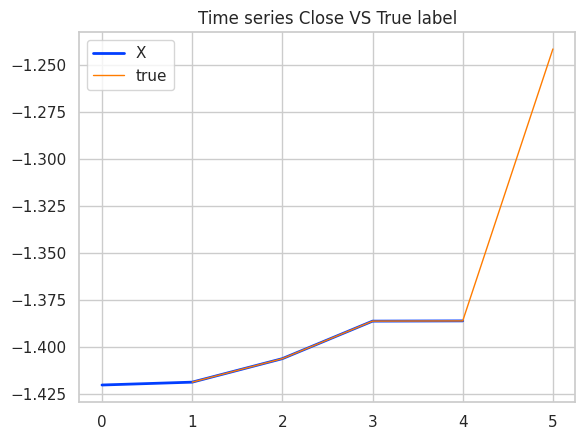

In [59]:
config = {
  'batch_size': 64,
  'lr':2e-3,
  'epochs': 30,
}
#TODO: tune context_len and pred_len
context_len=5
pred_len=1
window_len=context_len+pred_len
training_indices = get_windows(X_train, window_len, step_size=1) #TODO: Tune step size...
val_indices = get_windows(X_val,window_len, step_size=1) #TODO: Tune step size...
test_indices = get_windows(X_test, window_len, step_size=pred_len)

print(training_indices)
train_data=TSDataset(torch.FloatTensor(X_train), training_indices, window_len, pred_len=pred_len)
val_data=TSDataset(torch.FloatTensor(X_val), val_indices, window_len, pred_len=pred_len)
test_data=TSDataset(torch.FloatTensor(X_test), test_indices, window_len, pred_len=pred_len)

train_loader = torch.utils.data.DataLoader(
    dataset     = train_data,
    batch_size  = config['batch_size'],
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset     = val_data,
    batch_size  = 24,
    shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    dataset     = test_data,
    batch_size  = 24,
    pin_memory  = False,
    shuffle=False
)

for batch in train_loader:
    x, y_train=batch
    print(y_train.shape, x.shape)
    print("x: ", x[0,:,0]) #0 is the closing price
    print("y_train: ", y_train[0,:])  #True label should shift by one to right
    plt.plot(x[0,:,0], linewidth=2, label ="X")
    plt.plot(np.arange(pred_len, window_len), y_train[0,:], linewidth=1, label ="true")
    plt.legend()
    plt.title("Time series Close VS True label")
    break

### **LSTM Model**

In [60]:
class LSTM_Block(nn.Module):
  def __init__(self, input_dim, output_dim, dropout=0.3):
    super(LSTM_Block, self).__init__()
    self.lstm = nn.LSTM(input_dim, output_dim, num_layers=1, dropout=dropout, bias=True, batch_first=True)
    # self.bn= nn.BatchNorm1d(output_dim)
    self.dp = nn.Dropout(dropout)
    # self.act = nn.LeakyReLU()
  def forward(self, x):
    out,_ = self.lstm(x)
    # out = self.bn(out.permute(0,2,1)).permute(0,2,1)
    out = self.dp(out)
    # out = self.act(out)
    return out

class LSTM(nn.Module):
    def __init__(self, input_dim, output_dim, d_model=512, dropout=0.3):
        super(LSTM, self).__init__()
        self.d_model=d_model
        self.model = torch.nn.Sequential(

            LSTM_Block(input_dim, d_model),
            LSTM_Block(d_model, d_model),
            nn.Linear(d_model,d_model),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model,output_dim)
        )


    def forward(self, x):
        return self.model(x)


In [61]:
#TODO: tune model parameters
model=LSTM(input_dim=X_train.shape[-1], output_dim=1, d_model=512, dropout=0.5).to(device)
# print(x.size)
for x, y in train_loader:
    x=torch.FloatTensor(x).to(device)
    y=torch.FloatTensor(y).to(device)
    print(x[0,:,0], y[0])
    print("x shape:",x.shape, "y shape:", y.shape)
    out=model(x)
    print("out shape:", out.shape)
    summary(model,x)
    break

tensor([-0.9618, -0.8796, -1.0022, -0.9909, -0.9922], device='cuda:0') tensor([-0.8796, -1.0022, -0.9909, -0.9922, -0.9757], device='cuda:0')
x shape: torch.Size([64, 5, 205]) y shape: torch.Size([64, 5])
out shape: torch.Size([64, 5, 1])
                     Kernel Shape  Output Shape     Params  Mult-Adds
Layer                                                                
0_model.0.LSTM_lstm             -  [64, 5, 512]  1.472512M  1.468416M
1_model.0.Dropout_dp            -  [64, 5, 512]          -          -
2_model.1.LSTM_lstm             -  [64, 5, 512]  2.101248M  2.097152M
3_model.1.Dropout_dp            -  [64, 5, 512]          -          -
4_model.Linear_2       [512, 512]  [64, 5, 512]   262.656k   262.144k
5_model.LeakyReLU_3             -  [64, 5, 512]          -          -
6_model.Dropout_4               -  [64, 5, 512]          -          -
7_model.Linear_5         [512, 1]    [64, 5, 1]      513.0      512.0
-------------------------------------------------------------

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


In [62]:
optimizer   = torch.optim.AdamW(model.parameters(), lr= config['lr'], weight_decay = 1e-3)
criterion   = torch.nn.MSELoss()
scaler      = torch.cuda.amp.GradScaler()
scheduler   = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)
# Optional (but Recommended): Create a custom class for a Teacher Force Schedule

In [63]:
def train():
      model.train() # set to training mode
      model.to(device)

      batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      running_loss        = 0.0

      for i, batch in enumerate(train_loader):
          optimizer.zero_grad()

          x, y_train = batch

          x = x.to(device)
          y_train = y_train.to(device)
          y_pred = model(x)

          loss = criterion(y_pred[:,-pred_len:], y_train.unsqueeze(-1)[:,-pred_len:])   #TODO: try changing 8 to others, if want the model to learn other columns
          loss.backward()
          optimizer.step()

          # train_plot.append(loss.item())
          running_loss += loss.item()

          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1)),
              lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])),
              # teacher_time="{:.04f}".format(teach/10)
               )
          batch_bar.update()

          del x, y_train, y_pred
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(train_loader)

def validate():
      model.eval() # set to training mode
      model.to(device)

      batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      running_loss        = 0.0

      for i, batch in enumerate(val_loader):
          optimizer.zero_grad()
          x, y_test = batch

          x = x.to(device)
          y_test = y_test.to(device)

          y_pred = model(x)
          val_loss = criterion(y_pred[:,-pred_len:], y_test.unsqueeze(-1)[:,-pred_len:])    #TODO: try changing 8 to others, if want the model to learn other columns

          running_loss += val_loss.item()

          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1))
               )
          batch_bar.update()

          del x, y_test
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(val_loader)

def test(test_loader):
        model.eval() # set to training mode
        model.to(device)
        batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
        prediction=[]
        true_labels = []
        for i, batch in enumerate(test_loader):
            optimizer.zero_grad()
            x, y_test = batch
            x = x.to(device)

            y_pred = model(x)[:,:,0] #take tomorrow
            prediction.append(y_pred[:,-pred_len:].cpu().detach().numpy())
            true_labels.append(y_test[:,-pred_len:].cpu().detach().numpy())

            del x, y_test
            torch.cuda.empty_cache()
            batch_bar.update()

        batch_bar.close()


        return np.concatenate(prediction)*train_std[0][0]+train_mean[0][0], \
               np.concatenate(true_labels)*train_std[0][0]+train_mean[0][0]

### **Train Loop**

In [64]:
# optimizer.param_groups[0]['lr']=1e-4
train_loss_plot=[]
val_loss_plot=[]
num_epochs=50
for epoch in range(0, num_epochs):

    # Call train and validate
    print("\nEpoch: {}/{}".format(epoch+1, num_epochs))

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_loss              = train()
    train_loss_plot.append(train_loss)

    val_loss              = validate()
    val_loss_plot.append(val_loss)

    # trainer.teacher_forcing_ratio=max(trainer.teacher_forcing_ratio-0.05,0.1)
    scheduler.step()

    print("\tTrain Loss {:.04f}\t Learning Rate {:.07f}\t Validation Loss {:.04f}".format(train_loss, curr_lr, val_loss))



Epoch: 1/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.9277	 Learning Rate 0.0020000	 Validation Loss 0.5177

Epoch: 2/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.7993	 Learning Rate 0.0016000	 Validation Loss 0.5059

Epoch: 3/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.4454	 Learning Rate 0.0012800	 Validation Loss 0.5439

Epoch: 4/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1982	 Learning Rate 0.0010240	 Validation Loss 0.6926

Epoch: 5/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2894	 Learning Rate 0.0008192	 Validation Loss 0.6833

Epoch: 6/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1266	 Learning Rate 0.0006554	 Validation Loss 0.6574

Epoch: 7/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0870	 Learning Rate 0.0005243	 Validation Loss 0.6442

Epoch: 8/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1022	 Learning Rate 0.0004194	 Validation Loss 0.6413

Epoch: 9/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1342	 Learning Rate 0.0003355	 Validation Loss 0.6449

Epoch: 10/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1273	 Learning Rate 0.0002684	 Validation Loss 0.6511

Epoch: 11/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1054	 Learning Rate 0.0002147	 Validation Loss 0.6583

Epoch: 12/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0801	 Learning Rate 0.0001718	 Validation Loss 0.6656

Epoch: 13/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0898	 Learning Rate 0.0001374	 Validation Loss 0.6727

Epoch: 14/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0908	 Learning Rate 0.0001100	 Validation Loss 0.6793

Epoch: 15/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0832	 Learning Rate 0.0000880	 Validation Loss 0.6849

Epoch: 16/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0822	 Learning Rate 0.0000704	 Validation Loss 0.6897

Epoch: 17/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0877	 Learning Rate 0.0000563	 Validation Loss 0.6937

Epoch: 18/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0754	 Learning Rate 0.0000450	 Validation Loss 0.6969

Epoch: 19/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0656	 Learning Rate 0.0000360	 Validation Loss 0.6992

Epoch: 20/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0681	 Learning Rate 0.0000288	 Validation Loss 0.7010

Epoch: 21/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0788	 Learning Rate 0.0000231	 Validation Loss 0.7025

Epoch: 22/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0725	 Learning Rate 0.0000184	 Validation Loss 0.7038

Epoch: 23/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0867	 Learning Rate 0.0000148	 Validation Loss 0.7048

Epoch: 24/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0678	 Learning Rate 0.0000118	 Validation Loss 0.7057

Epoch: 25/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0746	 Learning Rate 0.0000094	 Validation Loss 0.7064

Epoch: 26/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0688	 Learning Rate 0.0000076	 Validation Loss 0.7070

Epoch: 27/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0834	 Learning Rate 0.0000060	 Validation Loss 0.7075

Epoch: 28/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0612	 Learning Rate 0.0000048	 Validation Loss 0.7079

Epoch: 29/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0827	 Learning Rate 0.0000039	 Validation Loss 0.7081

Epoch: 30/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0902	 Learning Rate 0.0000031	 Validation Loss 0.7083

Epoch: 31/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0655	 Learning Rate 0.0000025	 Validation Loss 0.7085

Epoch: 32/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0736	 Learning Rate 0.0000020	 Validation Loss 0.7086

Epoch: 33/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0663	 Learning Rate 0.0000016	 Validation Loss 0.7087

Epoch: 34/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0935	 Learning Rate 0.0000013	 Validation Loss 0.7088

Epoch: 35/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0791	 Learning Rate 0.0000010	 Validation Loss 0.7089

Epoch: 36/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0944	 Learning Rate 0.0000008	 Validation Loss 0.7089

Epoch: 37/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0738	 Learning Rate 0.0000006	 Validation Loss 0.7090

Epoch: 38/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0817	 Learning Rate 0.0000005	 Validation Loss 0.7090

Epoch: 39/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0812	 Learning Rate 0.0000004	 Validation Loss 0.7090

Epoch: 40/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0910	 Learning Rate 0.0000003	 Validation Loss 0.7091

Epoch: 41/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0639	 Learning Rate 0.0000003	 Validation Loss 0.7091

Epoch: 42/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0477	 Learning Rate 0.0000002	 Validation Loss 0.7091

Epoch: 43/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0707	 Learning Rate 0.0000002	 Validation Loss 0.7091

Epoch: 44/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0801	 Learning Rate 0.0000001	 Validation Loss 0.7091

Epoch: 45/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0649	 Learning Rate 0.0000001	 Validation Loss 0.7091

Epoch: 46/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0456	 Learning Rate 0.0000001	 Validation Loss 0.7091

Epoch: 47/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0713	 Learning Rate 0.0000001	 Validation Loss 0.7091

Epoch: 48/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0577	 Learning Rate 0.0000001	 Validation Loss 0.7091

Epoch: 49/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0758	 Learning Rate 0.0000000	 Validation Loss 0.7091

Epoch: 50/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0906	 Learning Rate 0.0000000	 Validation Loss 0.7091


Text(0.5, 1.0, 'Validation loss')

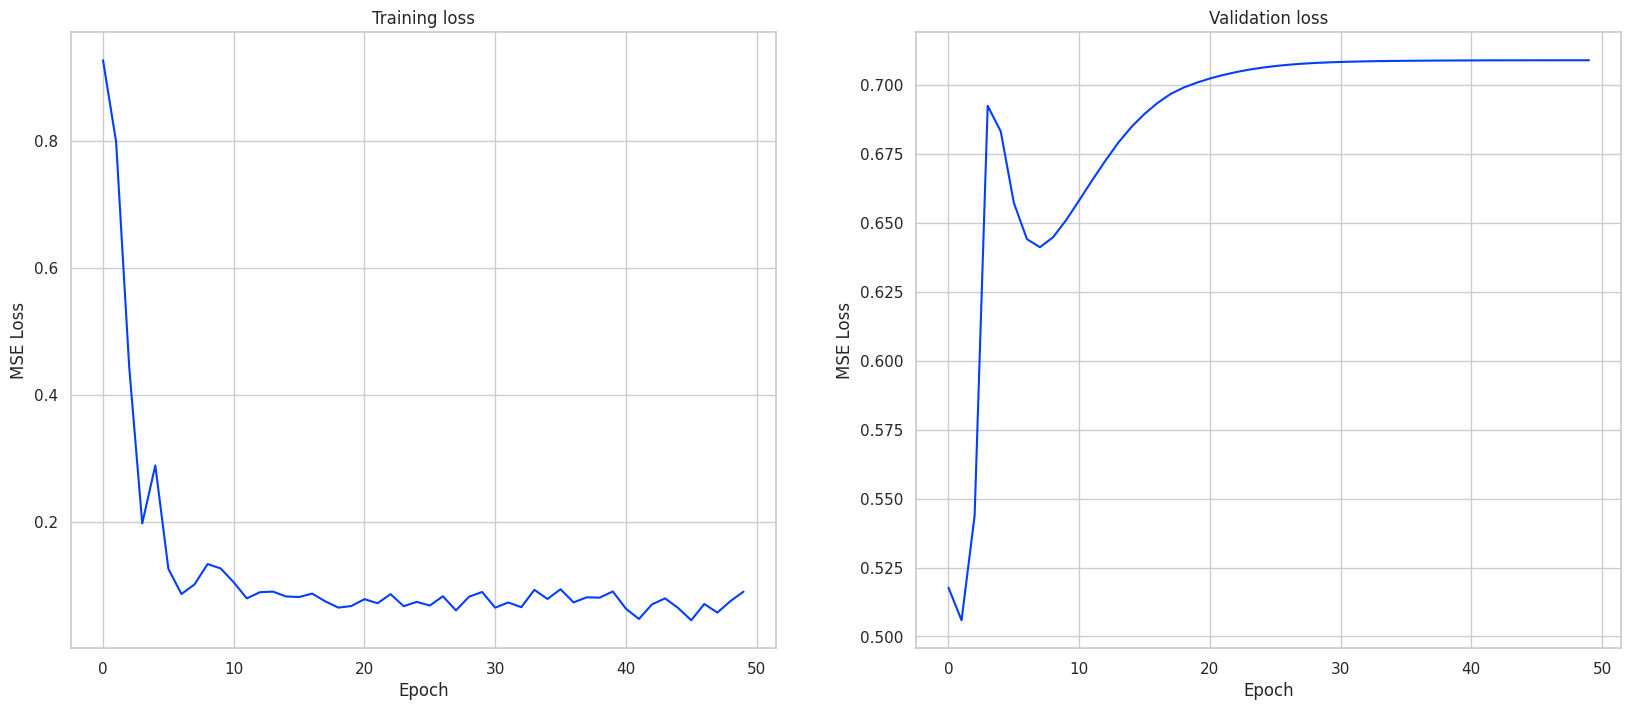

In [65]:
fig, ax=plt.subplots(1,2, figsize=(20,8))
# ax[0].plot(trainer.train_plot)
ax[0].plot(train_loss_plot)
ax[0].set_ylabel("MSE Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Training loss")

ax[1].plot(val_loss_plot)
ax[1].set_ylabel("MSE Loss")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Validation loss")


### **Evaluate and Inference**

In [66]:
prediction,true_labels=test(test_loader)
prediction = prediction.reshape(-1)
true_labels = true_labels.reshape(-1)
print(prediction.shape, true_labels.shape)
tfidf_test_metrics=get_metrics(prediction,true_labels)
tfidf_test_metrics

Train:   0%|          | 0/3 [00:00<?, ?it/s]

(59,) (59,)


MSE       RMSE      MAE      MAPE  Serial Corr  Pearson Corr(IC),  \
0  293.320953  17.126615  15.6576  0.486604     0.572026            0.10079   

   Spearman Corr(IC)  
0           0.082225

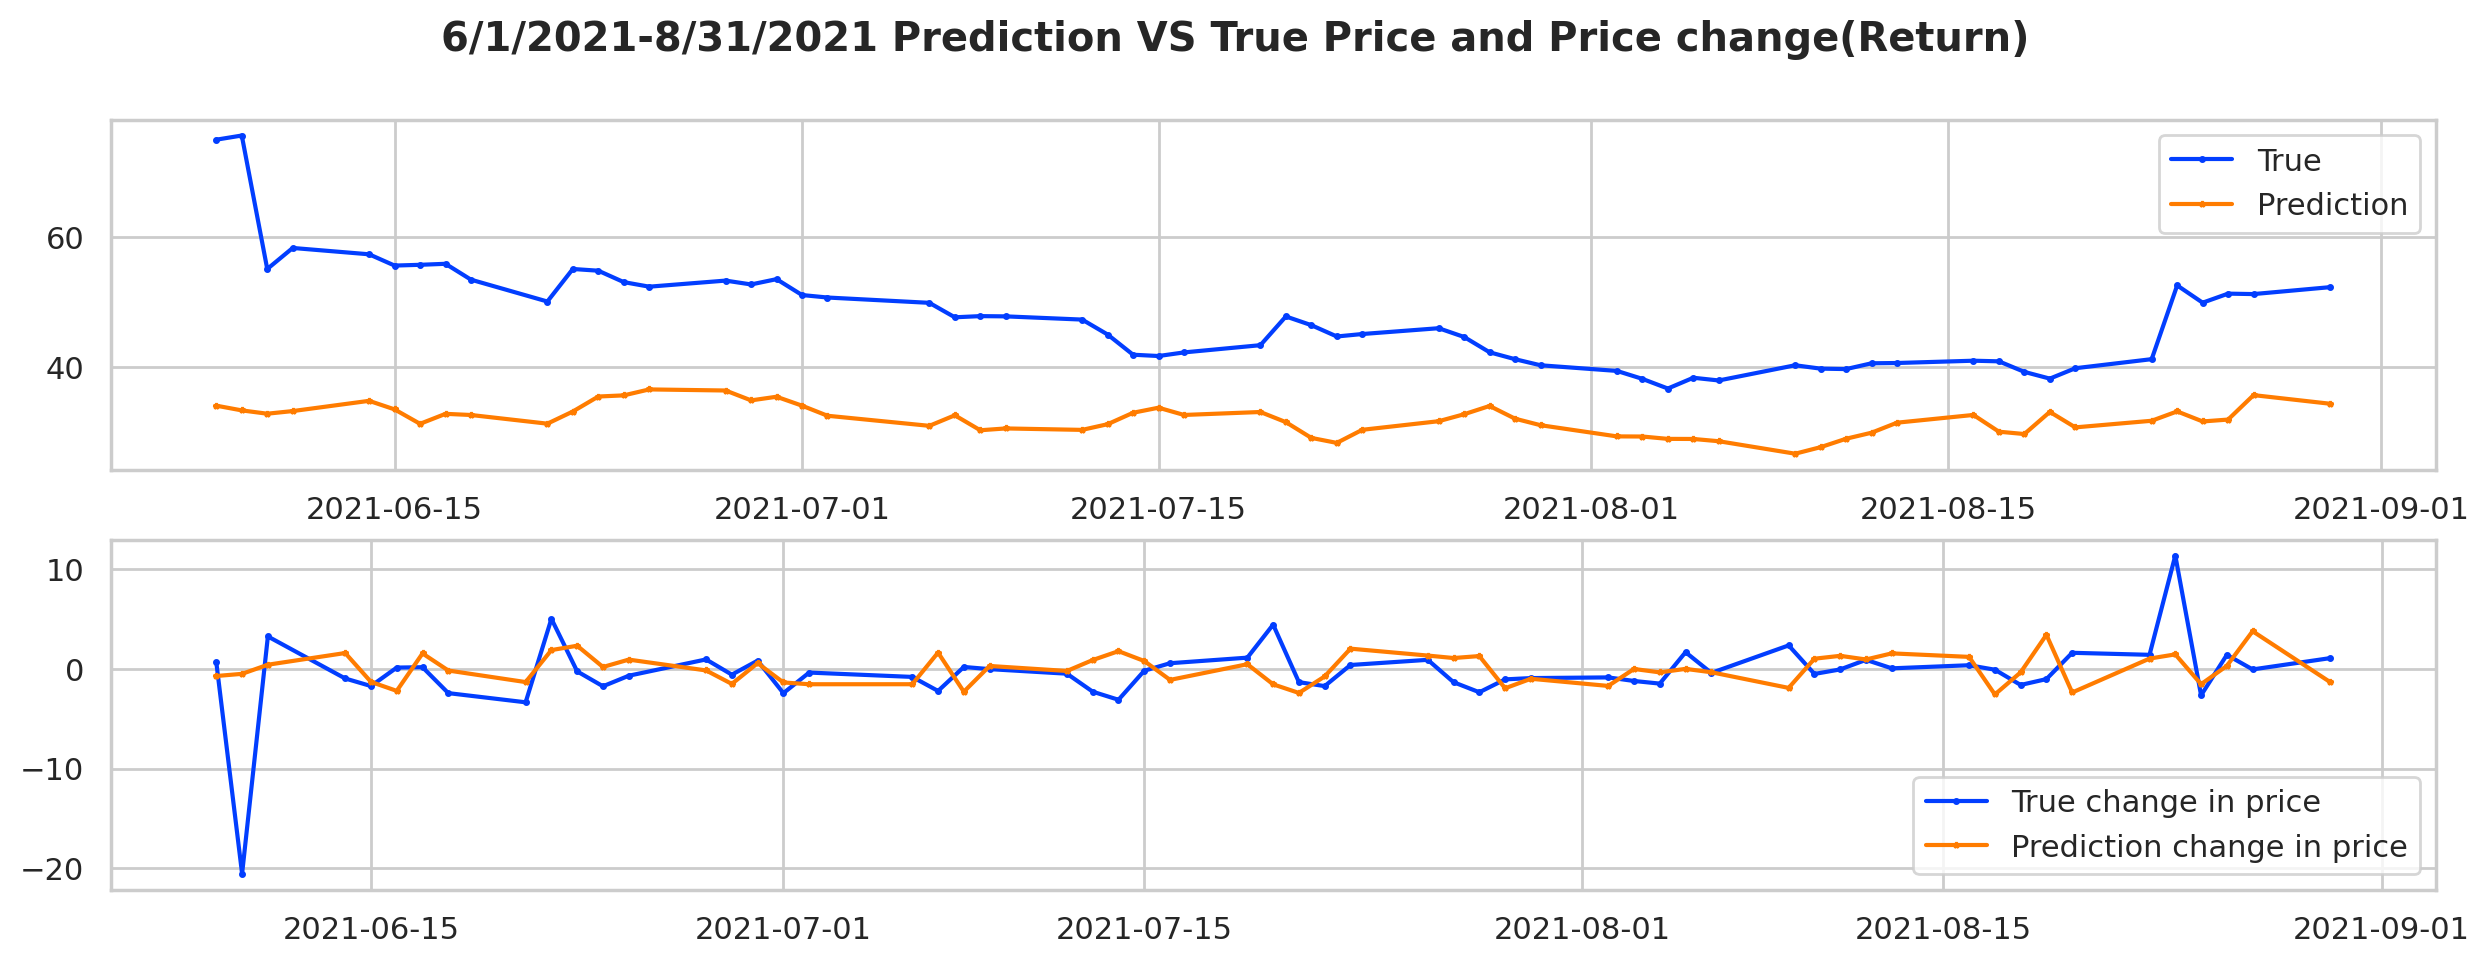

In [67]:
fig,ax=plt.subplots(2,1, figsize=(15,5),dpi=200)
date = df_ts[(df_ts.index>=pd.to_datetime("2021-06-08")) & (df_ts.index<=pd.to_datetime("2021-08-30"))].reset_index()['Date']
ax[0].plot(date, true_labels, label='True', marker='.', markersize=3)
ax[0].plot(date, prediction, label='Prediction',marker='*', markersize=2)
ax[0].legend()

ax[1].plot(date[1:], np.diff(true_labels), label='True change in price', marker='.', markersize=3)
ax[1].plot(date[1:],np.diff(prediction), label='Prediction change in price',marker='*', markersize=2)
ax[1].legend()
fig.suptitle("6/1/2021-8/31/2021 Prediction VS True Price and Price change(Return)", fontweight="bold")
plt.show()

In [68]:
inference_indices = get_windows(df_ts[df_ts.index<pd.to_datetime('2021-09-01')], window_len, step_size=pred_len)

inference_data=TSDataset(torch.FloatTensor(np.array(df_ts[df_ts.index<pd.to_datetime('2021-09-01')].values)), inference_indices, window_len, pred_len=pred_len)

inference_loader = torch.utils.data.DataLoader(
    dataset     = inference_data,
    batch_size  = len(inference_data),
    pin_memory  = False,
    shuffle=False
)
# inference_indices

In [69]:
prediction,true_labels=test(inference_loader)
prediction = prediction.reshape(-1)
true_labels = true_labels.reshape(-1)
print(prediction.shape, true_labels.shape)
tfidf_train_test_metrics=get_metrics(prediction,true_labels)
tfidf_train_test_metrics

Train:   0%|          | 0/1 [00:00<?, ?it/s]

(149,) (149,)


MSE       RMSE        MAE      MAPE  Serial Corr  Pearson Corr(IC),  \
0  193.997726  13.928307  10.132391  0.321734     0.730969           0.601619   

   Spearman Corr(IC)  
0           0.291034

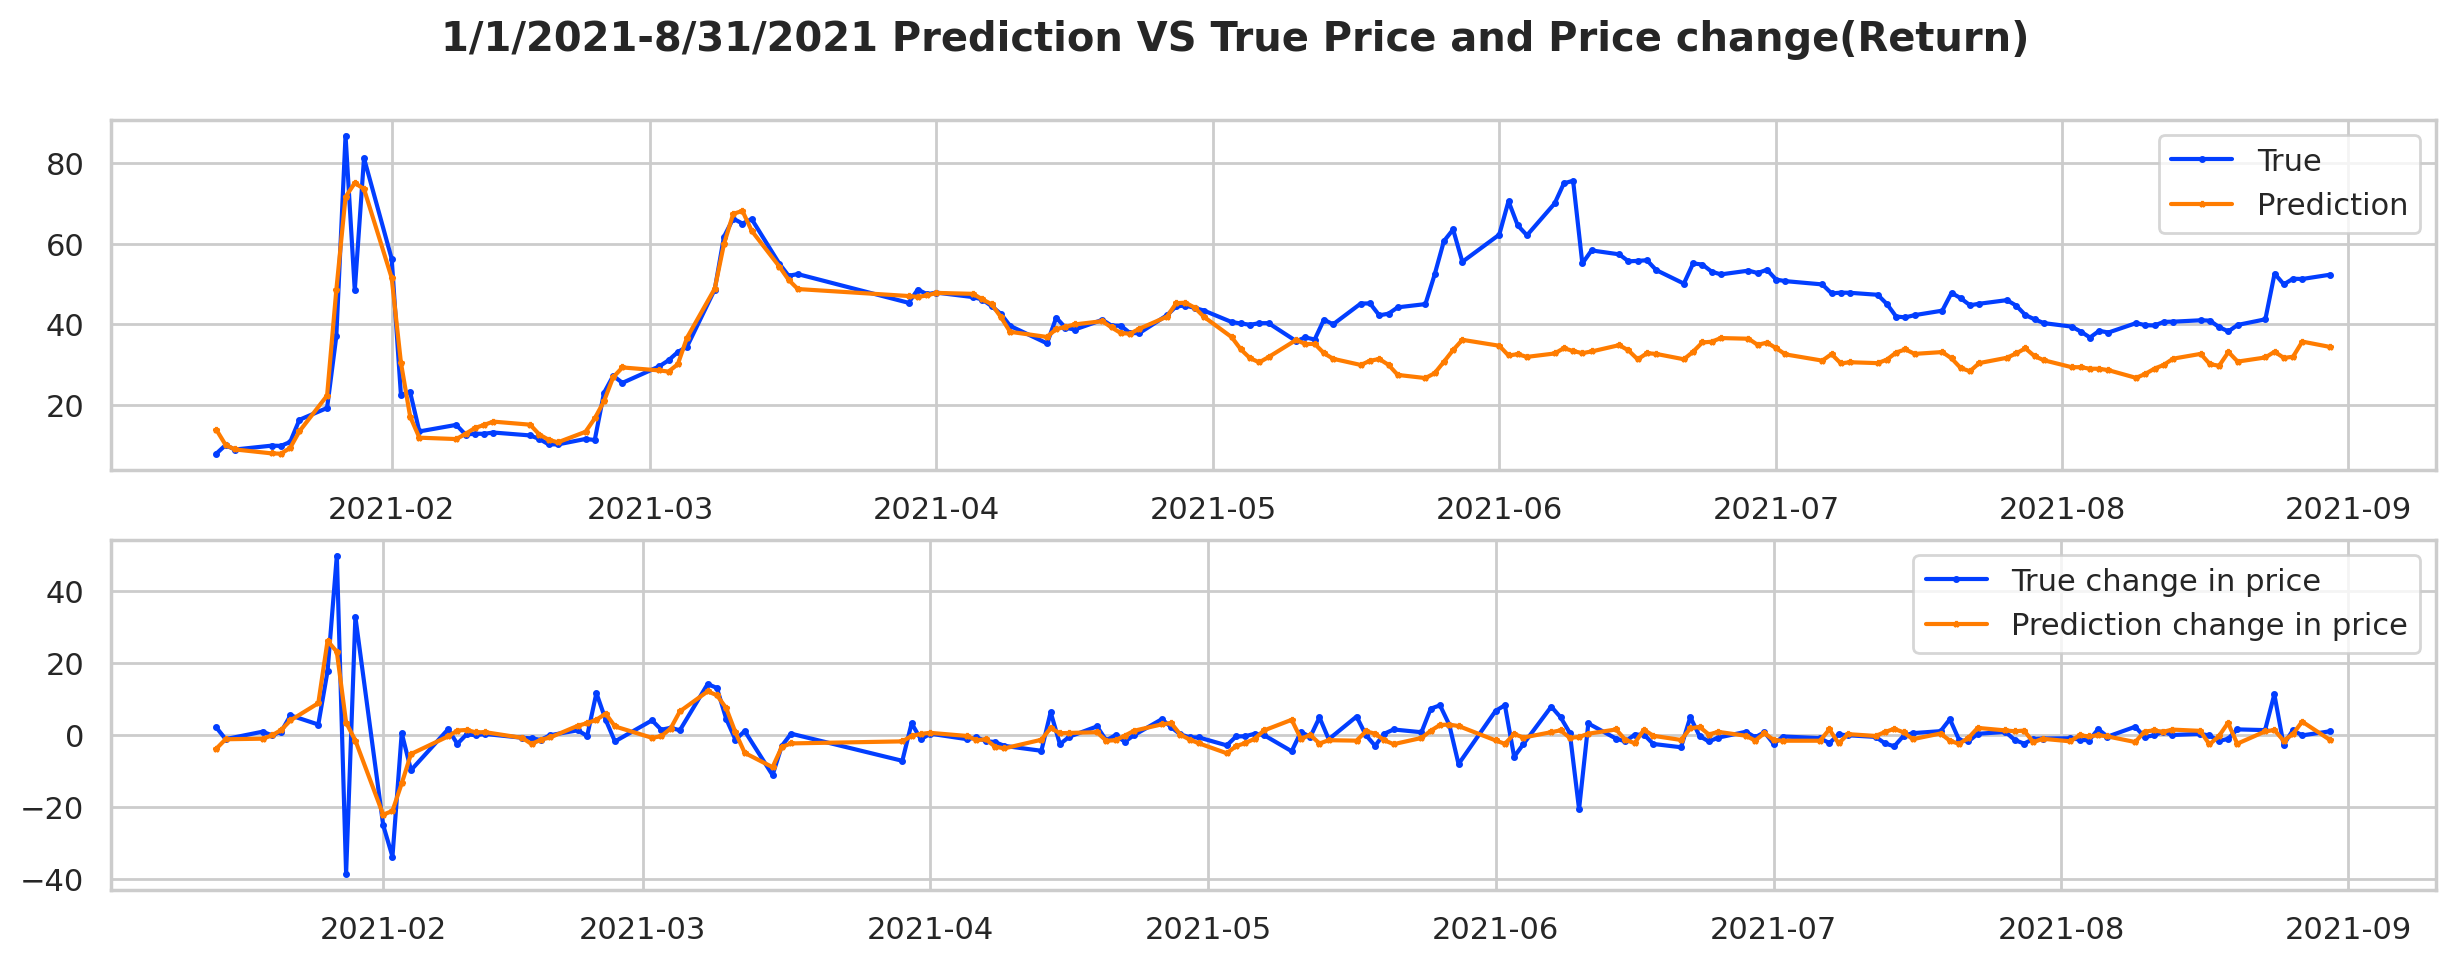

In [70]:
fig,ax=plt.subplots(2,1, figsize=(15,5),dpi=200)
date = df_ts[(df_ts.index>=pd.to_datetime("2021-01-13")) & (df_ts.index<=pd.to_datetime("2021-08-30"))].reset_index()['Date']
ax[0].plot(date,true_labels, label='True', marker='.', markersize=3)
ax[0].plot(date,prediction, label='Prediction',marker='*', markersize=2)
ax[0].legend()

ax[1].plot(date[1:], np.diff(true_labels), label='True change in price', marker='.', markersize=3)
ax[1].plot(date[1:], np.diff(prediction), label='Prediction change in price',marker='*', markersize=2)
ax[1].legend()
fig.suptitle("1/1/2021-8/31/2021 Prediction VS True Price and Price change(Return)", fontweight="bold")
plt.show()

# **Explore Bert Embeddings**

In [71]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# bert = BertModel.from_pretrained("bert-base-uncased").to(device)

## **Load my fine-tuned Bert to generate embeddings**

In [131]:
def tokenize(x):
  out = tokenizer.encode_plus(x,
        add_special_tokens=True,  # Add [CLS] and [SEP] tokens
        max_length=50,    # Truncate or pad to the maximum length
        truncation=True,          # Enable truncation if text is too long
        padding='max_length',     # Pad to the maximum length
        return_tensors='pt'       # Return PyTorch tensors)
  )
  return out
df_tokenized = df['title'].apply(lambda x: tokenize(x))
df_vec = df_tokenized.values
print("Shape of tokenized vector:",df_vec.shape)
print("shape of one news:", df_vec[0]['input_ids'].shape)
df_vec[0]

Shape of tokenized vector: (65061,)
shape of one news: torch.Size([1, 50])


{'input_ids': tensor([[  101,  2460, 11025, 14932,  7596,  7596,  7596,  7596,  7596,  7596,
          7596,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])}

In [132]:
class BERT(nn.Module):
    def __init__(self, bert):
        super(BERT, self).__init__()
        self.bert = bert
        self.mlp = nn.Sequential(
            nn.Linear(768,256),
            nn.LeakyReLU(),
            nn.Linear(256,256),
            nn.LeakyReLU(),
            nn.Linear(256,3)
        )

    def forward(self, x):
        input_ids= x[0].to(device)
        token_type= x[1].to(device)
        att_mask= x[2].to(device)
        out = self.bert(input_ids.to(device),  attention_mask=att_mask.to(device), token_type_ids=token_type.to(device))

        return self.mlp(out.pooler_output)

In [133]:
model = torch.load("/content/drive/MyDrive/94812/prediction/bert_finetuned.pt")
model((df_vec[0].input_ids.to(device), df_vec[0].token_type_ids.to(device), df_vec[0].attention_mask.to(device)))

tensor([[ 1.9833, -1.3301, -0.9498]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [134]:
class NLPDataset(torch.utils.data.Dataset):
    def __init__(self, data) :
        super().__init__()
        self.data = data
        self.input_ids = torch.vstack([i['input_ids'].squeeze() for i in data])
        self.token_type_ids = torch.vstack([i['token_type_ids'].squeeze() for i in data])
        self.att_mask = torch.vstack([i['attention_mask'].squeeze() for i in data])
        # self.label = torch.LongTensor(label)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):

        return (self.input_ids[index].to(device), self.token_type_ids[index].to(device), self.att_mask[index].to(device))

In [135]:
inference_data = NLPDataset(df_vec)
inference_loader = torch.utils.data.DataLoader(
    dataset     = inference_data,
    batch_size  = 256,
    shuffle=False
)
len(inference_data)
for X in inference_loader:
  print(len(X))
  print(X[0].shape, X[1].shape, X[2].shape)
  break
model.bert(input_ids=X[0], token_type_ids=X[1], attention_mask=X[2]).pooler_output.shape

3
torch.Size([256, 50]) torch.Size([256, 50]) torch.Size([256, 50])


torch.Size([256, 768])

In [136]:
embeddings = []
for X in tqdm(inference_loader, "inferencing..."):
  with torch.no_grad():
    res = model.bert(input_ids=X[0], token_type_ids=X[1], attention_mask=X[2]).pooler_output.cpu().detach().numpy()
    # print(res.shape)
    embeddings .append(res)
    del X
    gc.collect()
    torch.cuda.empty_cache()

embeddings = np.vstack(embeddings )
embeddings.shape

inferencing...:   0%|          | 0/255 [00:00<?, ?it/s]

(65061, 768)

## **Combine Time Series with Bert Embeddings.**

In [137]:
df_embeddings = pd.DataFrame(embeddings,columns=['dim'+str(i) for i in range(embeddings.shape[-1])])
df_embeddings['Date'] = df['Date']
df_embeddings = df_embeddings.groupby('Date').mean()
df_embeddings

dim0      dim1      dim2      dim3      dim4      dim5  \
Date                                                                     
2021-01-04 -0.839527 -0.424083 -0.761567  0.662155  0.450761 -0.177779   
2021-01-05 -0.645647 -0.214557  0.052024  0.301909 -0.188323  0.077009   
2021-01-06 -0.628741 -0.299113 -0.654147  0.409663  0.445411 -0.050049   
2021-01-11 -0.802747 -0.291301 -0.455577  0.563209  0.237437 -0.076465   
2021-01-12 -0.769426 -0.150443 -0.014803  0.306195 -0.156165 -0.082009   
...              ...       ...       ...       ...       ...       ...   
2021-12-27 -0.731301 -0.219534 -0.082929  0.467467  0.090359 -0.060763   
2021-12-28 -0.716466 -0.205016 -0.059851  0.450010  0.082908 -0.066626   
2021-12-29 -0.701200 -0.211514 -0.081056  0.454384  0.077569 -0.071647   
2021-12-30 -0.716122 -0.203090 -0.085930  0.447132  0.070816 -0.067789   
2021-12-31 -0.737479 -0.222051 -0.066202  0.462415  0.074810 -0.054440   

                dim6      dim7      dim8      dim9  ...    dim758    dim759  \
Date                                                ...                       
2021-01-04  0.661404  0.180796 -0.404010 -0.999967  ...  0.349083  0.094895   
2021-01-05  0.432468  0.036705  0.245787 -0.998497  ...  0.288688  0.605945   
2021-01-06  0.378659  0.173903 -0.174406 -0.997786  ...  0.396931  0.087815   
2021-01-11  0.544653  0.194068 -0.086913 -0.999832  ...  0.358911  0.071618   
2021-01-12  0.612291  0.131569  0.166596 -0.999605  ...  0.380514  0.499363   
...              ...       ...       ...       ...  ...       ...       ...   
2021-12-27  0.548617  0.105925  0.144904 -0.998491  ...  0.289725  0.355333   
2021-12-28  0.517623  0.095604  0.185321 -0.996564  ...  0.291866  0.407896   
2021-12-29  0.522776  0.104287  0.187025 -0.995669  ...  0.291046  0.423788   
2021-12-30  0.510352  0.116325  0.196949 -0.997353  ...  0.297969  0.421549   
2021-12-31  0.571745  0.119846  0.205303 -0.997543  ...  0.296382  0.346793   

              dim760    dim761    dim762    dim763    dim764    dim765  \
Date                                                                     
2021-01-04  0.929867  0.693200  0.033616  0.395849  0.379404 -0.602982   
2021-01-05 -0.044362  0.676697  0.785801  0.708676  0.422682 -0.098632   
2021-01-06  0.784068  0.727849 -0.380828  0.351390  0.450142 -0.663287   
2021-01-11  0.611937  0.734785  0.055054  0.554327  0.425337 -0.025344   
2021-01-12  0.112339  0.703219  0.009969  0.433367  0.419007  0.258986   
...              ...       ...       ...       ...       ...       ...   
2021-12-27  0.384333  0.771130  0.137902  0.617906  0.389913 -0.034690   
2021-12-28  0.349661  0.755477  0.180362  0.629007  0.390554 -0.059107   
2021-12-29  0.322462  0.749012  0.172054  0.597437  0.398743 -0.095335   
2021-12-30  0.327423  0.750512  0.151043  0.624101  0.400390 -0.085002   
2021-12-31  0.358021  0.777630  0.226978  0.653357  0.392597 -0.023507   

              dim766    dim767  
Date                            
2021-01-04 -0.601221  0.744309  
2021-01-05 -0.463653  0.738352  
2021-01-06 -0.467869  0.636216  
2021-01-11 -0.559318  0.834198  
2021-01-12 -0.452421  0.703244  
...              ...       ...  
2021-12-27 -0.505717  0.797597  
2021-12-28 -0.492742  0.786040  
2021-12-29 -0.504889  0.782664  
2021-12-30 -0.491849  0.784654  
2021-12-31 -0.509174  0.813304  

[240 rows x 768 columns]

In [138]:
dff = df[df.columns.difference(['title'])].groupby('Date').mean()
df_full = pd.concat([dff, df_embeddings],axis=1)
df_full

Close       High        Low       Open      Volume  \
Date                                                                 
2021-01-04   4.312500   4.775000   4.287500   4.750000  40090000.0   
2021-01-05   4.342500   4.520000   4.307500   4.337500  19846000.0   
2021-01-06   4.590000   4.745000   4.332500   4.335000  24224800.0   
2021-01-11   4.985000   5.162500   4.752500   4.852500  59632000.0   
2021-01-12   4.987500   5.100000   4.830000   4.990000  28242800.0   
...               ...        ...        ...        ...         ...   
2021-12-27  37.077499  38.154999  35.000000  38.000000   6454400.0   
2021-12-28  36.615002  39.352501  36.602501  36.875000   5324400.0   
2021-12-29  38.482498  38.872501  35.535000  36.962502   8149600.0   
2021-12-30  38.832500  40.000000  37.500000  37.750000   6247600.0   
2021-12-31  37.097500  39.182499  37.025002  38.404999   5576000.0   

            num_comments     score      dim0      dim1      dim2  ...  \
Date                                                              ...   
2021-01-04      5.000000  1.000000 -0.839527 -0.424083 -0.761567  ...   
2021-01-05      5.000000  1.000000 -0.645647 -0.214557  0.052024  ...   
2021-01-06     12.500000  1.000000 -0.628741 -0.299113 -0.654147  ...   
2021-01-11      9.500000  1.250000 -0.802747 -0.291301 -0.455577  ...   
2021-01-12     12.000000  1.500000 -0.769426 -0.150443 -0.014803  ...   
...                  ...       ...       ...       ...       ...  ...   
2021-12-27      0.007576  1.007576 -0.731301 -0.219534 -0.082929  ...   
2021-12-28      0.010753  1.005376 -0.716466 -0.205016 -0.059851  ...   
2021-12-29      0.010695  1.000000 -0.701200 -0.211514 -0.081056  ...   
2021-12-30      0.005556  1.022222 -0.716122 -0.203090 -0.085930  ...   
2021-12-31      0.013889  1.013889 -0.737479 -0.222051 -0.066202  ...   

              dim758    dim759    dim760    dim761    dim762    dim763  \
Date                                                                     
2021-01-04  0.349083  0.094895  0.929867  0.693200  0.033616  0.395849   
2021-01-05  0.288688  0.605945 -0.044362  0.676697  0.785801  0.708676   
2021-01-06  0.396931  0.087815  0.784068  0.727849 -0.380828  0.351390   
2021-01-11  0.358911  0.071618  0.611937  0.734785  0.055054  0.554327   
2021-01-12  0.380514  0.499363  0.112339  0.703219  0.009969  0.433367   
...              ...       ...       ...       ...       ...       ...   
2021-12-27  0.289725  0.355333  0.384333  0.771130  0.137902  0.617906   
2021-12-28  0.291866  0.407896  0.349661  0.755477  0.180362  0.629007   
2021-12-29  0.291046  0.423788  0.322462  0.749012  0.172054  0.597437   
2021-12-30  0.297969  0.421549  0.327423  0.750512  0.151043  0.624101   
2021-12-31  0.296382  0.346793  0.358021  0.777630  0.226978  0.653357   

              dim764    dim765    dim766    dim767  
Date                                                
2021-01-04  0.379404 -0.602982 -0.601221  0.744309  
2021-01-05  0.422682 -0.098632 -0.463653  0.738352  
2021-01-06  0.450142 -0.663287 -0.467869  0.636216  
2021-01-11  0.425337 -0.025344 -0.559318  0.834198  
2021-01-12  0.419007  0.258986 -0.452421  0.703244  
...              ...       ...       ...       ...  
2021-12-27  0.389913 -0.034690 -0.505717  0.797597  
2021-12-28  0.390554 -0.059107 -0.492742  0.786040  
2021-12-29  0.398743 -0.095335 -0.504889  0.782664  
2021-12-30  0.400390 -0.085002 -0.491849  0.784654  
2021-12-31  0.392597 -0.023507 -0.509174  0.813304  

[240 rows x 775 columns]

In [139]:
df_ts=df_full[df_full.columns.difference(['Date','num_comments','score'])].reset_index()
# df_ts=df_full.reset_index()
df_ts['Date'] = pd.to_datetime(df_ts['Date'])
# df_ts['sentiment'] = df_sentiment['sentiment']
df_ts.index=df_ts['Date']
df_ts = df_ts.drop(columns='Date')
df_ts

Close       High        Low       Open      Volume      dim0  \
Date                                                                           
2021-01-04   4.312500   4.775000   4.287500   4.750000  40090000.0 -0.839527   
2021-01-05   4.342500   4.520000   4.307500   4.337500  19846000.0 -0.645647   
2021-01-06   4.590000   4.745000   4.332500   4.335000  24224800.0 -0.628741   
2021-01-11   4.985000   5.162500   4.752500   4.852500  59632000.0 -0.802747   
2021-01-12   4.987500   5.100000   4.830000   4.990000  28242800.0 -0.769426   
...               ...        ...        ...        ...         ...       ...   
2021-12-27  37.077499  38.154999  35.000000  38.000000   6454400.0 -0.731301   
2021-12-28  36.615002  39.352501  36.602501  36.875000   5324400.0 -0.716466   
2021-12-29  38.482498  38.872501  35.535000  36.962502   8149600.0 -0.701200   
2021-12-30  38.832500  40.000000  37.500000  37.750000   6247600.0 -0.716122   
2021-12-31  37.097500  39.182499  37.025002  38.404999   5576000.0 -0.737479   

                dim1     dim10    dim100    dim101  ...     dim90     dim91  \
Date                                                ...                       
2021-01-04 -0.424083 -0.238887 -0.017671 -0.157559  ...  0.411837 -0.069524   
2021-01-05 -0.214557  0.367529  0.034623 -0.121090  ...  0.201836 -0.036980   
2021-01-06 -0.299113 -0.249750  0.054943 -0.112898  ...  0.491068 -0.149110   
2021-01-11 -0.291301  0.072107  0.027417 -0.150878  ...  0.355077 -0.127279   
2021-01-12 -0.150443  0.197225  0.005379 -0.144763  ...  0.340767 -0.075115   
...              ...       ...       ...       ...  ...       ...       ...   
2021-12-27 -0.219534  0.132327 -0.009954 -0.069562  ...  0.367980 -0.041308   
2021-12-28 -0.205016  0.183195 -0.023609 -0.053418  ...  0.337490 -0.031750   
2021-12-29 -0.211514  0.157174 -0.012423 -0.075512  ...  0.345257 -0.035115   
2021-12-30 -0.203090  0.187029 -0.021487 -0.059637  ...  0.339296 -0.028205   
2021-12-31 -0.222051  0.165079 -0.021248 -0.073641  ...  0.347231 -0.043576   

               dim92     dim93     dim94     dim95     dim96     dim97  \
Date                                                                     
2021-01-04  0.357766  0.383963 -0.166471 -0.393023 -0.226149 -0.780693   
2021-01-05  0.128356  0.302147 -0.080309 -0.184914 -0.023092  0.216623   
2021-01-06  0.356828  0.362787 -0.197846 -0.385284 -0.125539 -0.496077   
2021-01-11 -0.042195  0.354187 -0.091750 -0.312719 -0.179920 -0.366954   
2021-01-12 -0.024135  0.394696 -0.292610 -0.294580 -0.139294  0.256641   
...              ...       ...       ...       ...       ...       ...   
2021-12-27 -0.095315  0.294055 -0.030898 -0.215783 -0.102146 -0.137719   
2021-12-28 -0.081794  0.302938 -0.021859 -0.215165 -0.074615 -0.110007   
2021-12-29 -0.031184  0.309317 -0.060238 -0.234752 -0.087045 -0.108340   
2021-12-30 -0.040187  0.309623 -0.041354 -0.215951 -0.072249 -0.114636   
2021-12-31 -0.137882  0.299762  0.001527 -0.203632 -0.099021 -0.115674   

               dim98     dim99  
Date                            
2021-01-04 -0.221504 -0.268770  
2021-01-05 -0.105075  0.096137  
2021-01-06 -0.287380 -0.247983  
2021-01-11 -0.195913 -0.225368  
2021-01-12 -0.172245 -0.037738  
...              ...       ...  
2021-12-27 -0.180682 -0.174956  
2021-12-28 -0.148306 -0.165983  
2021-12-29 -0.162782 -0.182189  
2021-12-30 -0.159356 -0.173902  
2021-12-31 -0.163002 -0.155605  

[240 rows x 773 columns]

# **Training with Bert embeddings**

### **Train Test Split**

In [140]:
total_len = len(df_ts)

train = df_ts[df_ts.index<pd.to_datetime("2021-05-01")]
val   = df_ts[(df_ts.index < pd.to_datetime("2021-06-01")) & (df_ts.index > pd.to_datetime("2021-05-01"))]
test  = df_ts[(df_ts.index < pd.to_datetime("2021-09-01")) & (df_ts.index > pd.to_datetime("2021-05-31"))]
print("train_len",len(train)/total_len,"val_len", len(val)/total_len,"test_len", len(test)/total_len)

train_len 0.2916666666666667 val_len 0.08333333333333333 test_len 0.2708333333333333


In [141]:
X_train = np.array(train.values)
X_val = np.array(val.values)
X_test = np.array(test.values)
factor_name = train.columns
print(factor_name)
X_train.shape, X_val.shape, X_test.shape


Index(['Close', 'High', 'Low', 'Open', 'Volume', 'dim0', 'dim1', 'dim10',
       'dim100', 'dim101',
       ...
       'dim90', 'dim91', 'dim92', 'dim93', 'dim94', 'dim95', 'dim96', 'dim97',
       'dim98', 'dim99'],
      dtype='object', length=773)


((70, 773), (20, 773), (65, 773))

In [142]:
train_mean = np.mean(X_train, axis=0, keepdims = True)
train_std = np.std(X_train, axis=0, keepdims = True)

### **Dataset & DataLoader**

In [143]:
class TSDataset(torch.utils.data.Dataset):
    def __init__(self, data, indices, seq_len, pred_len=20) :
        super().__init__()
        self.data = (data-torch.FloatTensor(train_mean))/torch.FloatTensor(train_std)
        self.indices = indices
        self.seq_len = seq_len
        self.pred_len= pred_len

    def __len__(self):
        return len(self.indices)

    def get_sequence(self, sequence, seq_len) :

        x = sequence[0:-self.pred_len,:]     #0~7 close open high low volume
        y = sequence[self.pred_len:,0]     #8 close

        return x, y

    def __getitem__(self, index):
        start, end = self.indices[index]
        sequence = self.data[start:end]
        x, y = self.get_sequence(sequence, self.seq_len)

        return x, y

def get_windows(data, window_size, step_size=1):
    # Start the first sub-sequence at index position 0
    start = 0
    end = window_size

    indices = []
    while end <= len(data)-1:      #proceed window by step size, count how many sequences
        indices.append((start, end))
        start += step_size
        end += step_size
    return indices

[(0, 6), (1, 7), (2, 8), (3, 9), (4, 10), (5, 11), (6, 12), (7, 13), (8, 14), (9, 15), (10, 16), (11, 17), (12, 18), (13, 19), (14, 20), (15, 21), (16, 22), (17, 23), (18, 24), (19, 25), (20, 26), (21, 27), (22, 28), (23, 29), (24, 30), (25, 31), (26, 32), (27, 33), (28, 34), (29, 35), (30, 36), (31, 37), (32, 38), (33, 39), (34, 40), (35, 41), (36, 42), (37, 43), (38, 44), (39, 45), (40, 46), (41, 47), (42, 48), (43, 49), (44, 50), (45, 51), (46, 52), (47, 53), (48, 54), (49, 55), (50, 56), (51, 57), (52, 58), (53, 59), (54, 60), (55, 61), (56, 62), (57, 63), (58, 64), (59, 65), (60, 66), (61, 67), (62, 68), (63, 69)]
torch.Size([64, 5]) torch.Size([64, 5, 773])
x:  tensor([0.8215, 0.7628, 0.7834, 0.7265, 0.6955])
y_train:  tensor([0.7628, 0.7834, 0.7265, 0.6955, 0.6128])


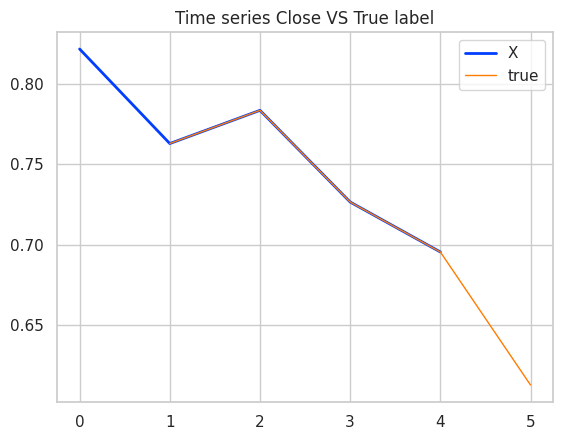

In [144]:
config = {
  'batch_size': 64,
  'lr':2e-3,
  'epochs': 30,
}
#TODO: tune context_len and pred_len
context_len=5
pred_len=1
window_len=context_len+pred_len
training_indices = get_windows(X_train, window_len, step_size=1) #TODO: Tune step size...
val_indices = get_windows(X_val,window_len, step_size=1) #TODO: Tune step size...
test_indices = get_windows(X_test, window_len, step_size=pred_len)

print(training_indices)
train_data=TSDataset(torch.FloatTensor(X_train), training_indices, window_len, pred_len=pred_len)
val_data=TSDataset(torch.FloatTensor(X_val), val_indices, window_len, pred_len=pred_len)
test_data=TSDataset(torch.FloatTensor(X_test), test_indices, window_len, pred_len=pred_len)

train_loader = torch.utils.data.DataLoader(
    dataset     = train_data,
    batch_size  = config['batch_size'],
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset     = val_data,
    batch_size  = 24,
    shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    dataset     = test_data,
    batch_size  = 24,
    pin_memory  = False,
    shuffle=False
)

for batch in train_loader:
    x, y_train=batch
    print(y_train.shape, x.shape)
    print("x: ", x[0,:,0]) #0 is the closing price
    print("y_train: ", y_train[0,:])  #True label should shift by one to right
    plt.plot(x[0,:,0], linewidth=2, label ="X")
    plt.plot(np.arange(pred_len, window_len), y_train[0,:], linewidth=1, label ="true")
    plt.legend()
    plt.title("Time series Close VS True label")
    break

### **LSTM Model**

In [145]:
class LSTM_Block(nn.Module):
  def __init__(self, input_dim, output_dim, dropout=0.3):
    super(LSTM_Block, self).__init__()
    self.lstm = nn.LSTM(input_dim, output_dim, num_layers=1, dropout=dropout, bias=True, batch_first=True)
    # self.bn= nn.BatchNorm1d(output_dim)
    self.dp = nn.Dropout(dropout)
    # self.act = nn.LeakyReLU()
  def forward(self, x):
    out,_ = self.lstm(x)
    # out = self.bn(out.permute(0,2,1)).permute(0,2,1)
    out = self.dp(out)
    # out = self.act(out)
    return out

class LSTM(nn.Module):
    def __init__(self, input_dim, output_dim, d_model=512, dropout=0.3):
        super(LSTM, self).__init__()
        self.d_model=d_model
        self.model = torch.nn.Sequential(

            LSTM_Block(input_dim, d_model),
            LSTM_Block(d_model, d_model),
            nn.Linear(d_model,d_model),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model,output_dim)
        )
        # self.linear_scale = nn.Linear(2,1)
        # self.linear_out = nn.Linear(context_len*d_model, output_dim)

    def forward(self, x):
        return self.model(x) #+ x[:,:,0:1]
        # return self.linear_out(self.model(x).flatten(1)).unsqueeze(1) #+ x[:,:,0:1]
        # return self.linear_scale(torch.cat([self.model(x) , x[:,:,0:1]],dim=-1))


In [146]:
#TODO: tune model parameters
model=LSTM(input_dim=X_train.shape[-1], output_dim=1, d_model=512, dropout=0.5).to(device)
# print(x.size)
for x, y in train_loader:
    x=torch.FloatTensor(x).to(device)
    y=torch.FloatTensor(y).to(device)
    print(x[0,:,0], y[0])
    print("x shape:",x.shape, "y shape:", y.shape)
    out=model(x)
    print("out shape:", out.shape)
    summary(model,x)
    break

tensor([-1.0567, -1.0697, -0.4784, -0.2631, -0.3515], device='cuda:0') tensor([-1.0697, -0.4784, -0.2631, -0.3515, -0.1435], device='cuda:0')
x shape: torch.Size([64, 5, 773]) y shape: torch.Size([64, 5])
out shape: torch.Size([64, 5, 1])
                     Kernel Shape  Output Shape     Params  Mult-Adds
Layer                                                                
0_model.0.LSTM_lstm             -  [64, 5, 512]  2.635776M   2.63168M
1_model.0.Dropout_dp            -  [64, 5, 512]          -          -
2_model.1.LSTM_lstm             -  [64, 5, 512]  2.101248M  2.097152M
3_model.1.Dropout_dp            -  [64, 5, 512]          -          -
4_model.Linear_2       [512, 512]  [64, 5, 512]   262.656k   262.144k
5_model.LeakyReLU_3             -  [64, 5, 512]          -          -
6_model.Dropout_4               -  [64, 5, 512]          -          -
7_model.Linear_5         [512, 1]    [64, 5, 1]      513.0      512.0
-------------------------------------------------------------

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


In [147]:
optimizer   = torch.optim.AdamW(model.parameters(), lr= config['lr'], weight_decay = 1e-3)
criterion   = torch.nn.MSELoss()
scaler      = torch.cuda.amp.GradScaler()
scheduler   = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)
# Optional (but Recommended): Create a custom class for a Teacher Force Schedule

In [148]:
def train():
      model.train() # set to training mode
      model.to(device)

      batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      running_loss        = 0.0

      for i, batch in enumerate(train_loader):
          optimizer.zero_grad()

          x, y_train = batch

          x = x.to(device)
          y_train = y_train.to(device)
          y_pred = model(x)

          loss = criterion(y_pred[:,-pred_len:], y_train.unsqueeze(-1)[:,-pred_len:])   #TODO: try changing 8 to others, if want the model to learn other columns
          loss.backward()
          optimizer.step()

          # train_plot.append(loss.item())
          running_loss += loss.item()

          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1)),
              lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])),
              # teacher_time="{:.04f}".format(teach/10)
               )
          batch_bar.update()

          del x, y_train, y_pred
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(train_loader)

def validate():
      model.eval() # set to training mode
      model.to(device)

      batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      running_loss        = 0.0

      for i, batch in enumerate(val_loader):
          optimizer.zero_grad()
          x, y_test = batch

          x = x.to(device)
          y_test = y_test.to(device)

          y_pred = model(x)
          val_loss = criterion(y_pred[:,-pred_len:], y_test.unsqueeze(-1)[:,-pred_len:])    #TODO: try changing 8 to others, if want the model to learn other columns

          running_loss += val_loss.item()

          batch_bar.set_postfix(
              loss="{:.04f}".format(running_loss/(i+1))
               )
          batch_bar.update()

          del x, y_test
          torch.cuda.empty_cache()

      batch_bar.close()

      return running_loss/len(val_loader)

def test(test_loader):
        model.eval() # set to training mode
        model.to(device)
        batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
        prediction=[]
        true_labels = []
        for i, batch in enumerate(test_loader):
            optimizer.zero_grad()
            x, y_test = batch
            x = x.to(device)

            y_pred = model(x)[:,:,0] #take tomorrow
            prediction.append(y_pred[:,-pred_len:].cpu().detach().numpy())
            true_labels.append(y_test[:,-pred_len:].cpu().detach().numpy())

            del x, y_test
            torch.cuda.empty_cache()
            batch_bar.update()

        batch_bar.close()


        return np.concatenate(prediction)*train_std[0][0]+train_mean[0][0], \
               np.concatenate(true_labels)*train_std[0][0]+train_mean[0][0]

### **Train Loop**

In [149]:
# optimizer.param_groups[0]['lr']=1e-4
train_loss_plot=[]
val_loss_plot=[]
num_epochs=50
for epoch in range(0, num_epochs):

    # Call train and validate
    print("\nEpoch: {}/{}".format(epoch+1, num_epochs))

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_loss              = train()
    train_loss_plot.append(train_loss)

    val_loss              = validate()
    val_loss_plot.append(val_loss)

    # trainer.teacher_forcing_ratio=max(trainer.teacher_forcing_ratio-0.05,0.1)
    scheduler.step()

    print("\tTrain Loss {:.04f}\t Learning Rate {:.07f}\t Validation Loss {:.04f}".format(train_loss, curr_lr, val_loss))



Epoch: 1/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.9257	 Learning Rate 0.0020000	 Validation Loss 0.3077

Epoch: 2/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.7699	 Learning Rate 0.0016000	 Validation Loss 0.3553

Epoch: 3/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.6556	 Learning Rate 0.0012800	 Validation Loss 0.1914

Epoch: 4/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3810	 Learning Rate 0.0010240	 Validation Loss 0.2341

Epoch: 5/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.3412	 Learning Rate 0.0008192	 Validation Loss 0.1943

Epoch: 6/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.2109	 Learning Rate 0.0006554	 Validation Loss 0.1425

Epoch: 7/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1610	 Learning Rate 0.0005243	 Validation Loss 0.1321

Epoch: 8/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1269	 Learning Rate 0.0004194	 Validation Loss 0.1413

Epoch: 9/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1405	 Learning Rate 0.0003355	 Validation Loss 0.1395

Epoch: 10/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1251	 Learning Rate 0.0002684	 Validation Loss 0.1338

Epoch: 11/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0996	 Learning Rate 0.0002147	 Validation Loss 0.1349

Epoch: 12/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1167	 Learning Rate 0.0001718	 Validation Loss 0.1432

Epoch: 13/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1135	 Learning Rate 0.0001374	 Validation Loss 0.1509

Epoch: 14/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1004	 Learning Rate 0.0001100	 Validation Loss 0.1541

Epoch: 15/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0885	 Learning Rate 0.0000880	 Validation Loss 0.1534

Epoch: 16/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0973	 Learning Rate 0.0000704	 Validation Loss 0.1509

Epoch: 17/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0762	 Learning Rate 0.0000563	 Validation Loss 0.1474

Epoch: 18/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0789	 Learning Rate 0.0000450	 Validation Loss 0.1439

Epoch: 19/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0907	 Learning Rate 0.0000360	 Validation Loss 0.1410

Epoch: 20/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0887	 Learning Rate 0.0000288	 Validation Loss 0.1386

Epoch: 21/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0893	 Learning Rate 0.0000231	 Validation Loss 0.1369

Epoch: 22/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0721	 Learning Rate 0.0000184	 Validation Loss 0.1355

Epoch: 23/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0973	 Learning Rate 0.0000148	 Validation Loss 0.1346

Epoch: 24/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0689	 Learning Rate 0.0000118	 Validation Loss 0.1338

Epoch: 25/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0610	 Learning Rate 0.0000094	 Validation Loss 0.1333

Epoch: 26/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0884	 Learning Rate 0.0000076	 Validation Loss 0.1328

Epoch: 27/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0786	 Learning Rate 0.0000060	 Validation Loss 0.1325

Epoch: 28/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0652	 Learning Rate 0.0000048	 Validation Loss 0.1323

Epoch: 29/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0786	 Learning Rate 0.0000039	 Validation Loss 0.1321

Epoch: 30/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0694	 Learning Rate 0.0000031	 Validation Loss 0.1319

Epoch: 31/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0915	 Learning Rate 0.0000025	 Validation Loss 0.1318

Epoch: 32/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0985	 Learning Rate 0.0000020	 Validation Loss 0.1317

Epoch: 33/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.1005	 Learning Rate 0.0000016	 Validation Loss 0.1316

Epoch: 34/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0827	 Learning Rate 0.0000013	 Validation Loss 0.1316

Epoch: 35/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0842	 Learning Rate 0.0000010	 Validation Loss 0.1315

Epoch: 36/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0628	 Learning Rate 0.0000008	 Validation Loss 0.1315

Epoch: 37/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0801	 Learning Rate 0.0000006	 Validation Loss 0.1315

Epoch: 38/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0695	 Learning Rate 0.0000005	 Validation Loss 0.1314

Epoch: 39/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0621	 Learning Rate 0.0000004	 Validation Loss 0.1314

Epoch: 40/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0801	 Learning Rate 0.0000003	 Validation Loss 0.1314

Epoch: 41/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0727	 Learning Rate 0.0000003	 Validation Loss 0.1314

Epoch: 42/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0766	 Learning Rate 0.0000002	 Validation Loss 0.1314

Epoch: 43/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0736	 Learning Rate 0.0000002	 Validation Loss 0.1314

Epoch: 44/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0763	 Learning Rate 0.0000001	 Validation Loss 0.1314

Epoch: 45/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0739	 Learning Rate 0.0000001	 Validation Loss 0.1314

Epoch: 46/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0923	 Learning Rate 0.0000001	 Validation Loss 0.1314

Epoch: 47/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0947	 Learning Rate 0.0000001	 Validation Loss 0.1314

Epoch: 48/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0729	 Learning Rate 0.0000001	 Validation Loss 0.1314

Epoch: 49/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0728	 Learning Rate 0.0000000	 Validation Loss 0.1314

Epoch: 50/50


Train:   0%|          | 0/1 [00:00<?, ?it/s]

Train:   0%|          | 0/1 [00:00<?, ?it/s]

	Train Loss 0.0870	 Learning Rate 0.0000000	 Validation Loss 0.1314


Text(0.5, 1.0, 'Validation loss')

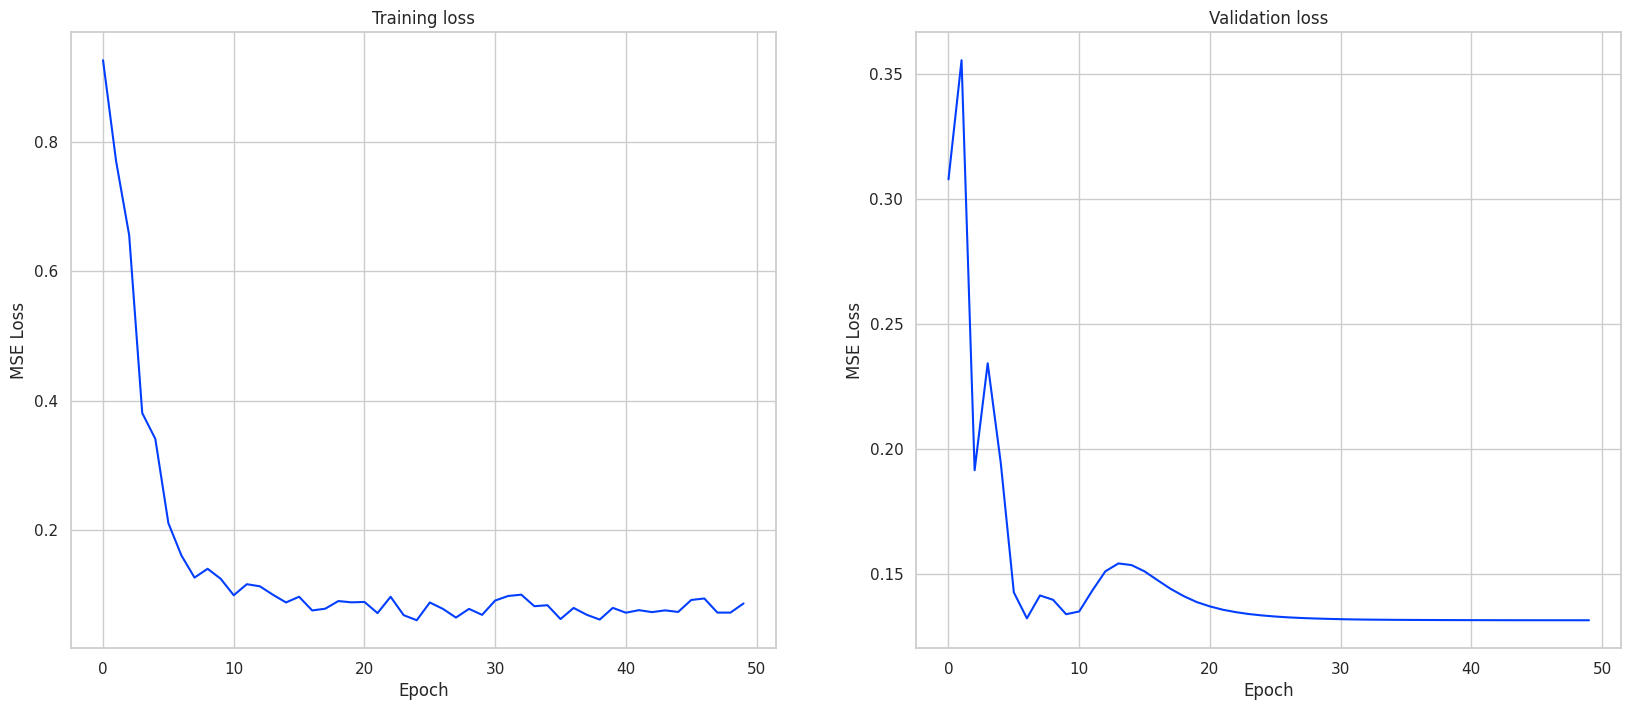

In [150]:
fig, ax=plt.subplots(1,2, figsize=(20,8))
# ax[0].plot(trainer.train_plot)
ax[0].plot(train_loss_plot)
ax[0].set_ylabel("MSE Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Training loss")

ax[1].plot(val_loss_plot)
ax[1].set_ylabel("MSE Loss")
ax[1].set_xlabel("Epoch")
ax[1].set_title("Validation loss")


### **Evaluate and Inference**

In [151]:
prediction,true_labels=test(test_loader)
prediction = prediction.reshape(-1)
true_labels = true_labels.reshape(-1)
prediction.shape, true_labels.shape
bert_embeddings_test_metrics = get_metrics(prediction,true_labels)
bert_embeddings_test_metrics

Train:   0%|          | 0/3 [00:00<?, ?it/s]

MSE      RMSE       MAE      MAPE  Serial Corr  Pearson Corr(IC),  \
0  81.09124  9.005067  6.601645  0.160148     0.227988           0.202719   

   Spearman Corr(IC)  
0           0.212867

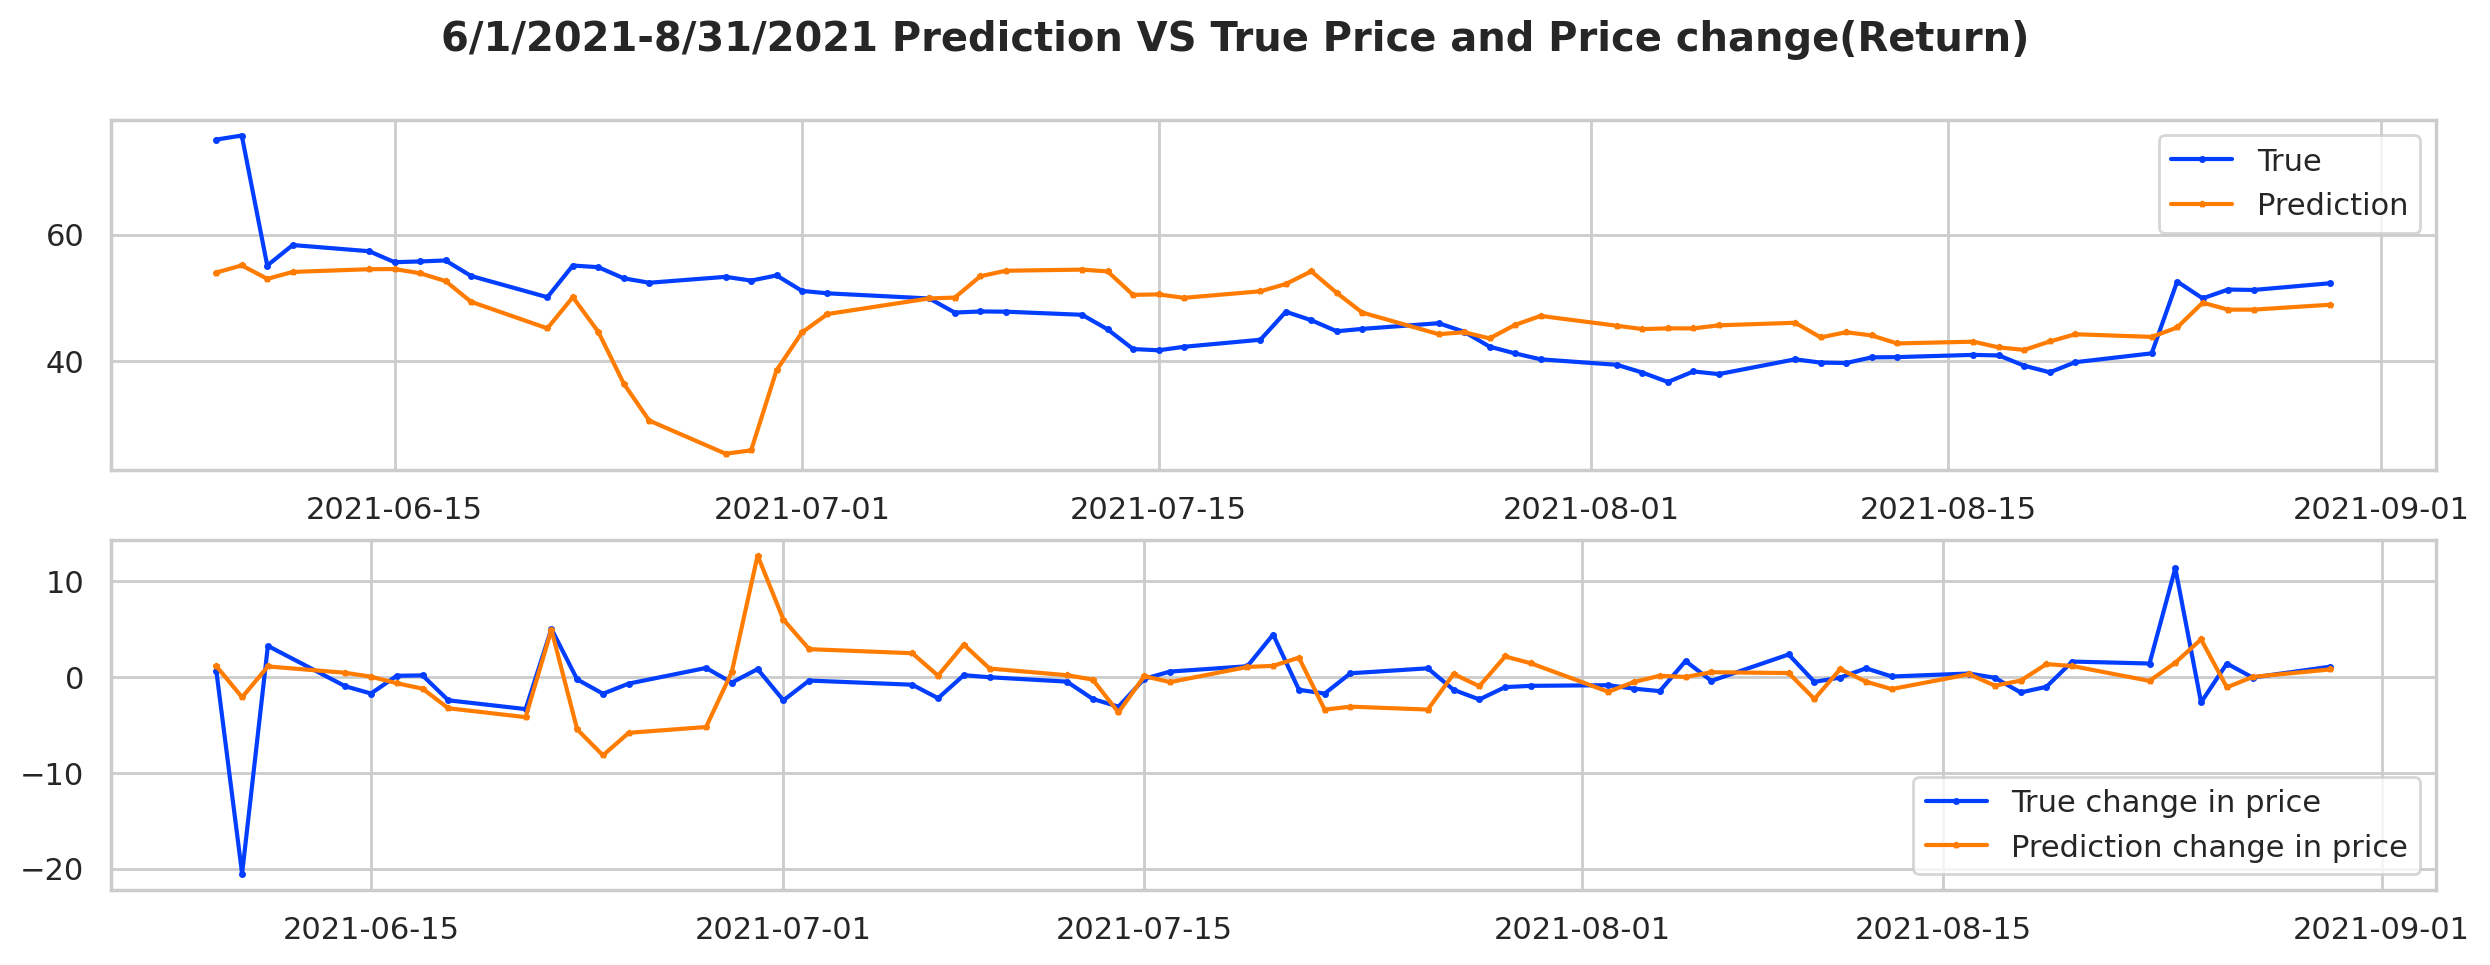

In [152]:
fig,ax=plt.subplots(2,1, figsize=(15,5),dpi=200)
date = df_ts[(df_ts.index>=pd.to_datetime("2021-06-08")) & (df_ts.index<=pd.to_datetime("2021-08-30"))].reset_index()['Date']
ax[0].plot(date, true_labels, label='True', marker='.', markersize=3)
ax[0].plot(date, prediction, label='Prediction',marker='*', markersize=2)
ax[0].legend()

ax[1].plot(date[1:], np.diff(true_labels), label='True change in price', marker='.', markersize=3)
ax[1].plot(date[1:],np.diff(prediction), label='Prediction change in price',marker='*', markersize=2)
ax[1].legend()
fig.suptitle("6/1/2021-8/31/2021 Prediction VS True Price and Price change(Return)", fontweight="bold")
plt.show()

In [153]:
df_inferencing = df_ts[df_ts.index<pd.to_datetime('2021-09-01')]
inference_indices = get_windows(df_inferencing, window_len, step_size=pred_len)

inference_data=TSDataset(torch.FloatTensor(np.array(df_inferencing.values)), inference_indices, window_len, pred_len=pred_len)

inference_loader = torch.utils.data.DataLoader(
    dataset     = inference_data,
    batch_size  = len(inference_data),
    pin_memory  = False,
    shuffle=False
)
# inference_indices

In [154]:
prediction,true_labels=test(inference_loader)
prediction = prediction.reshape(-1)
true_labels = true_labels.reshape(-1)
print(prediction.shape, true_labels.shape)
# print("Serial Correlation, True Correlation(IC)")
# print(np.corrcoef(prediction,true_labels)[0,1], np.corrcoef(np.diff(prediction),np.diff(true_labels))[0,1])
bert_embeddings_train_test_metrics = get_metrics(prediction,true_labels)
bert_embeddings_train_test_metrics

Train:   0%|          | 0/1 [00:00<?, ?it/s]

(149,) (149,)


MSE      RMSE       MAE      MAPE  Serial Corr  Pearson Corr(IC),  \
0  57.128338  7.558329  5.384109  0.143481     0.878441           0.650112   

   Spearman Corr(IC)  
0            0.34464

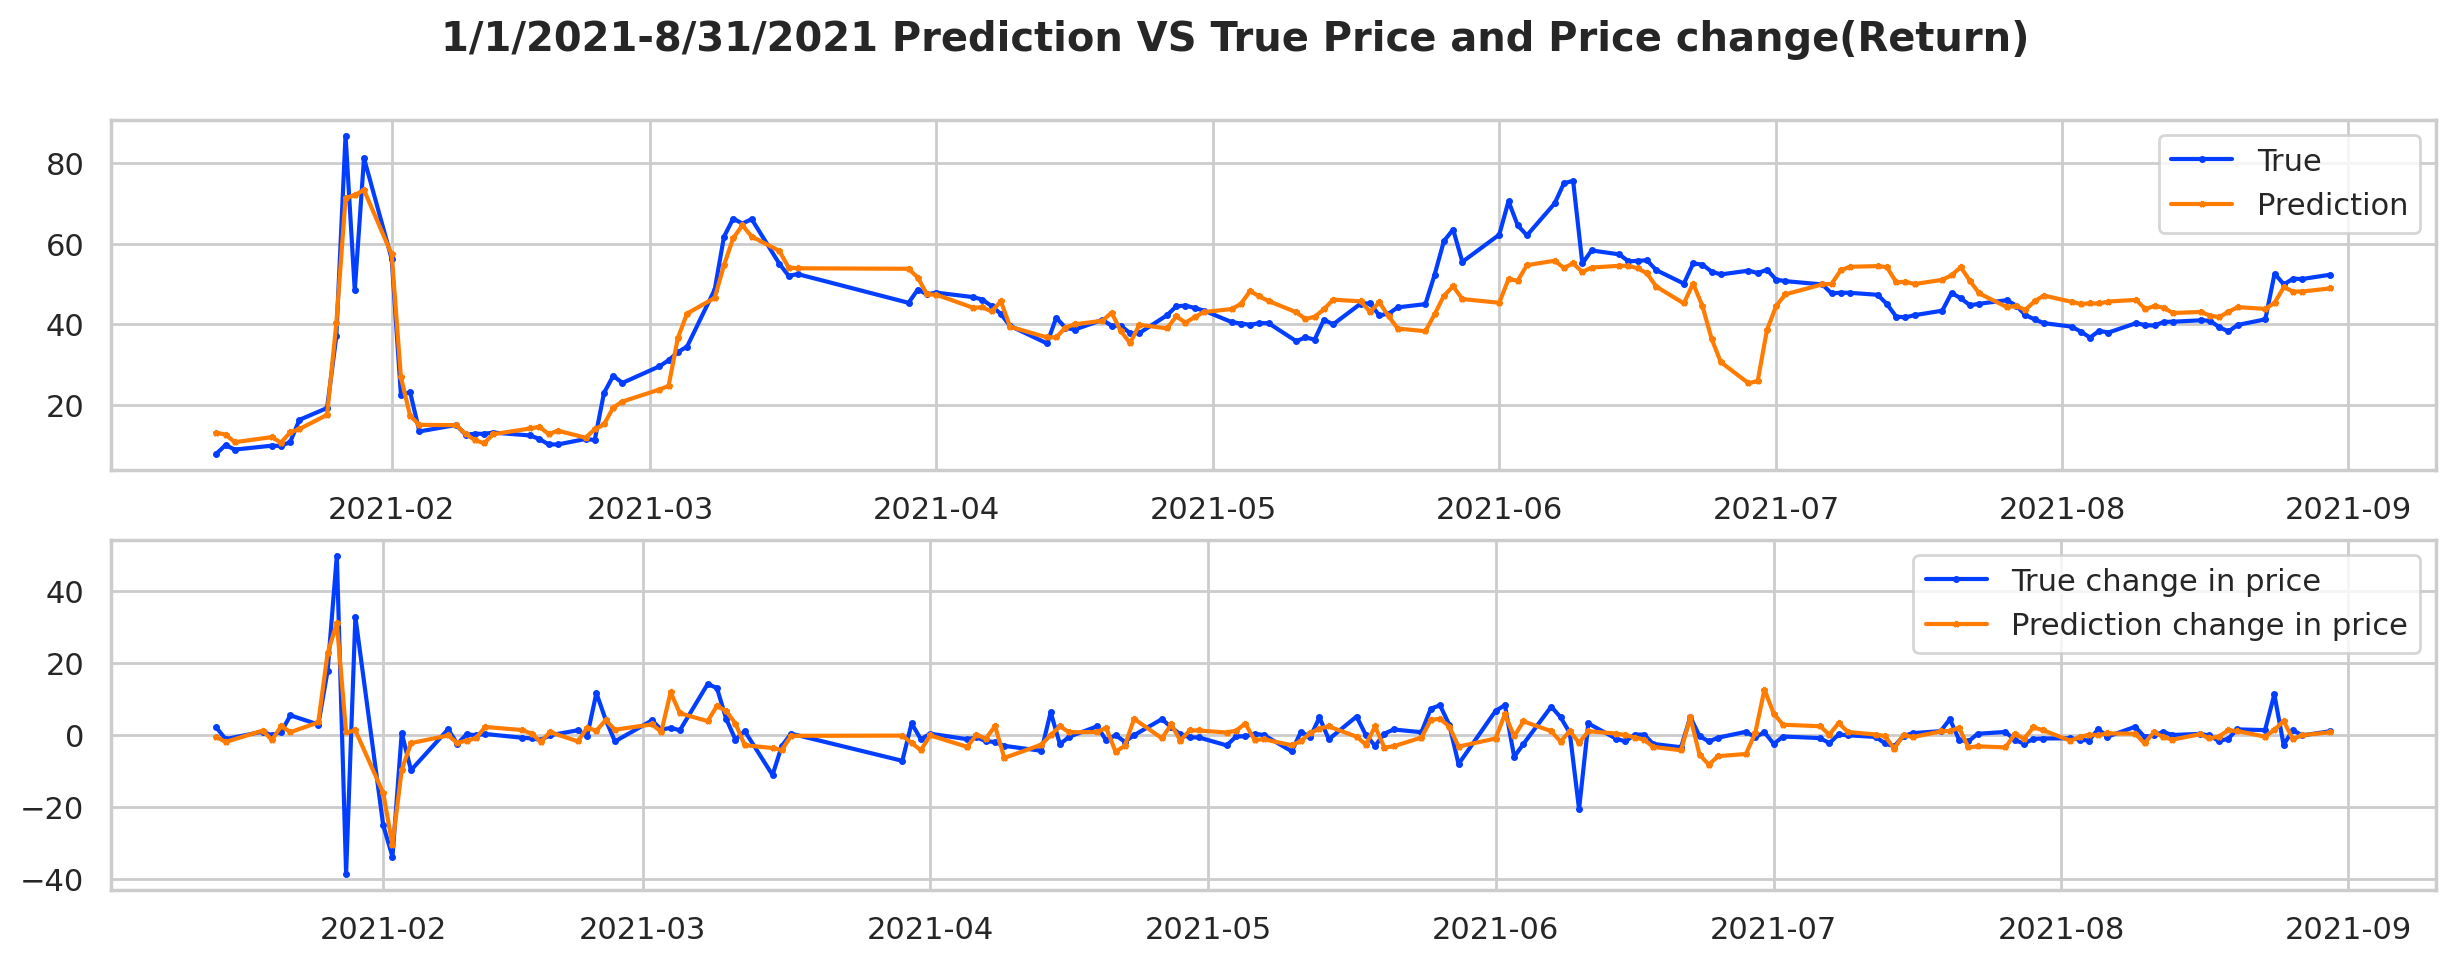

In [155]:
fig,ax=plt.subplots(2,1, figsize=(15,5),dpi=200)
date = df_ts[(df_ts.index>=pd.to_datetime("2021-01-13")) & (df_ts.index<=pd.to_datetime("2021-08-30"))].reset_index()['Date']
ax[0].plot(date,true_labels, label='True', marker='.', markersize=3)
ax[0].plot(date,prediction, label='Prediction',marker='*', markersize=2)
ax[0].legend()

ax[1].plot(date[1:],np.diff(true_labels), label='True change in price', marker='.', markersize=3)
ax[1].plot(date[1:], np.diff(prediction), label='Prediction change in price',marker='*', markersize=2)
ax[1].legend()
fig.suptitle("1/1/2021-8/31/2021 Prediction VS True Price and Price change(Return)", fontweight="bold")
plt.show()

# **Metrics**

In [156]:
df_metrics = pd.concat([baseline_test_metrics, tfidf_test_metrics, bert_embeddings_test_metrics])
df_metrics.index = ['Baseline_sentiment', 'TF-IDF', 'Bert_embeddings']
df_metrics

MSE       RMSE        MAE      MAPE  Serial Corr  \
Baseline_sentiment   69.992683   8.366163   5.953912  0.136495     0.871836   
TF-IDF              293.320953  17.126615  15.657600  0.486604     0.572026   
Bert_embeddings      81.091240   9.005067   6.601645  0.160148     0.227988   

                    Pearson Corr(IC),  Spearman Corr(IC)  
Baseline_sentiment          -0.179569          -0.090130  
TF-IDF                       0.100790           0.082225  
Bert_embeddings              0.202719           0.212867